# Linear regression with Eustatic Sea-level data

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a polynomial function to Eustatic Sea-level heights.

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

---

Data set is from "Sea level and global ice volumes from the Last Glacial Maximum to the Holocene"
K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi

Remember to uncomment and run the code cell below as well, as we are going to
load some data from GitHub.

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Linear regression

Lets start with some (x,y) data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#
def load_data_xy(filename):

    f = open(filename, 'r')
    header = f.readline()
    lines = f.readlines()

    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    for line in lines:
        columns = line.split()
        x = np.append(x,float(columns[0]))
        y = np.append(y,float(columns[1]))
        sx = np.append(sx,float(columns[2])/2.0)
        sy = np.append(sy,float(columns[3])/2.0)

    d = x,y, sy                                   # Combine into a single data structure

    return d

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [5]:
data_x,data_y,sy = load_data_xy("ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [6]:
maxtime = 20.
ndata = np.where(data_x>maxtime)[0][0]

In [7]:
data_x,data_y,sy = data_x[:ndata],data_y[:ndata],sy[:ndata]

And now lets plot the data.

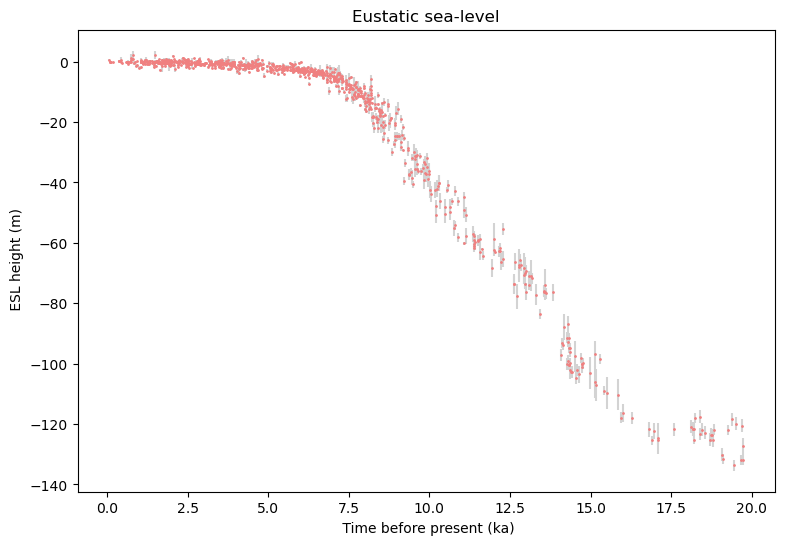

In [8]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)
plot_data(title='Eustatic sea-level')

## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem the forward operator takes the following form:

$$ \left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2$);
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).



We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [9]:
nparams = 5 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sy):
    factor= 10                                   # factor to inflate observational errors
    return np.diag(1./sy*1./sy)/(factor**2)

Define a reference model for later.

In [10]:
# Reference model for plotting
ESLref = load_data_ref("ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [11]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

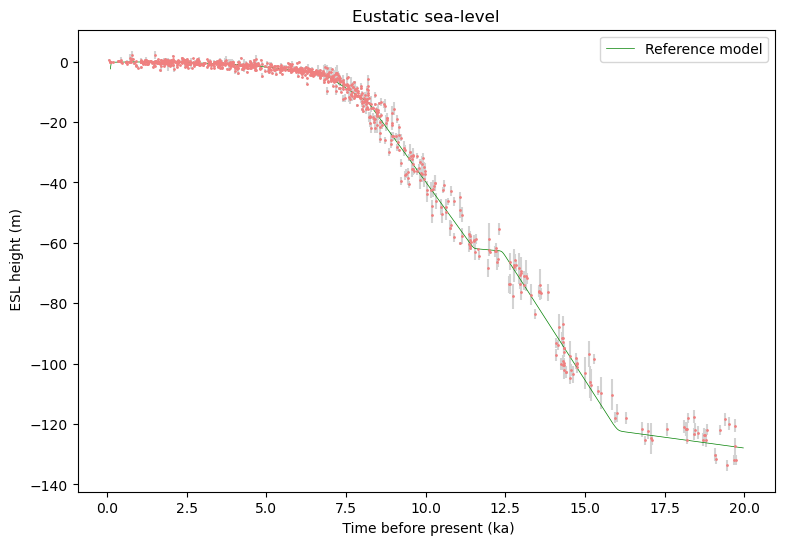

In [12]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

## 1. Linear system solver

In [13]:
from cofi import BaseProblem, InversionOptions, Inversion

### Step 1. Define CoFI `BaseProblem`

In [14]:
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

### Step 2. Define CoFI `InversionOptions`

In [15]:
inv_options = InversionOptions()

Using the information supplied, we can ask CoFI to suggest some solving methods.

In [16]:
inv_options.suggest_solving_methods()

The following solving methods are supported:
{'matrix solvers', 'optimization', 'sampling'}

Use `suggest_tools()` to see a full list of backend tools for each method


We can ask CoFI to suggest some specific software tools as well. 

In [17]:
inv_options.suggest_tools()

Here's a complete list of inversion tools supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee"
    ]
}


In [18]:
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'> (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [19]:
# below is optional, as this has already been the default tool under "linear least square"
inv_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case 
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution 

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

Lets run CoFI.

In [20]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [21]:
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]

Summary for inversion result
SUCCESS
----------------------------
model: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]
sum_of_squared_residuals: []
effective_rank: 5
singular_values: [1.72339368e+09 1.35569994e+06 3.54123758e+03 1.10384400e+02
 7.16903392e+00]
model_covariance: [[ 6.70145209e-02 -6.28173834e-02  1.67266578e-02 -1.60867740e-03
   4.77025592e-05]
 [-6.28173834e-02  7.43365995e-02 -2.23488563e-02  2.32179303e-03
  -7.20214235e-05]
 [ 1.67266578e-02 -2.23488563e-02  7.38371078e-03 -8.20763652e-04
   2.65025504e-05]
 [-1.60867740e-03  2.32179303e-03 -8.20763652e-04  9.62437921e-05
  -3.21300646e-06]
 [ 4.77025592e-05 -7.20214235e-05  2.65025504e-05 -3.21300646e-06
   1.10114955e-07]]


Lets plot the solution.

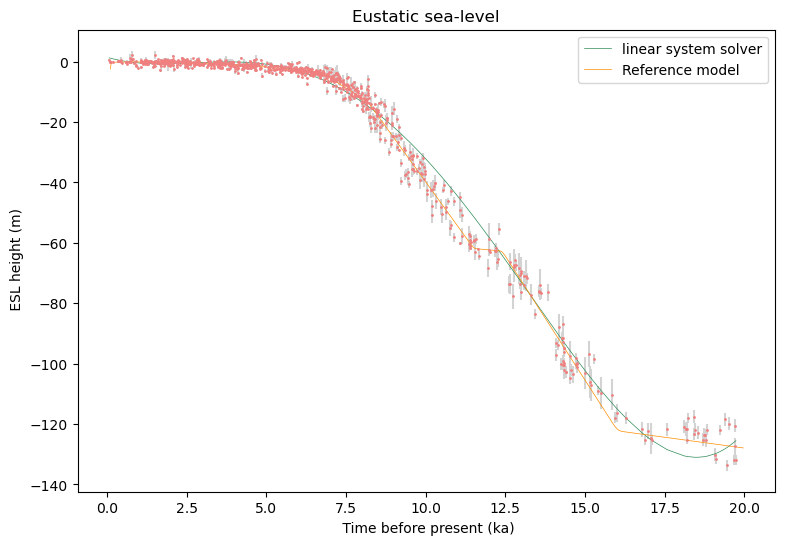

In [22]:
plot_data(title="Eustatic sea-level")
plot_model(data_x,jacobian(data_x).dot(inv_result.model), "linear system solver", color="seagreen")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where 
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularisation. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [23]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_initial_model(np.ones(nparams))
#inv_problem.set_initial_model(inv_result.model)
inv_problem.set_forward(forward)
inv_problem.set_data_misfit("squared error")

# inv_problem.set_objective(your_own_misfit_function)    # (optionally) if you'd like to define your own misfit
# inv_problem.set_gradient(your_own_gradient_of_misfit_function)    # (optionally) if you'd like to define your own misfit gradient

######## CoFI InversionOptions - set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")
inv_options_2.set_params(method="Nelder-Mead")

######## CoFI Inversion - run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]

Summary for inversion result
FAILURE
----------------------------
fun: 396.30180936007037
nit: 598
nfev: 1000
status: 1
message: Maximum number of function evaluations has been exceeded.
final_simplex: (array([[ 4.02211771, -7.6352002 ,  3.47983694, -0.52237961,  0.02043681],
       [ 4.02227491, -7.63498804,  3.47977907, -0.52238912,  0.02043829],
       [ 4.02218792, -7.63507241,  3.47979137, -0.5223722 ,  0.02043577],
       [ 4.02245903, -7.63488993,  3.47966829, -0.52235893,  0.02043602],
       [ 4.02257488, -7.63525136,  3.47962954, -0.52233062,  0.02043424],
       [ 4.02215782, -7.63502984,  3.47981924, -0.5223883 ,  0.02043736]]), array([396.30180936, 396.30181593, 396.30181983, 396.30182837,
       396.30183836, 396.30184074]))
model: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]


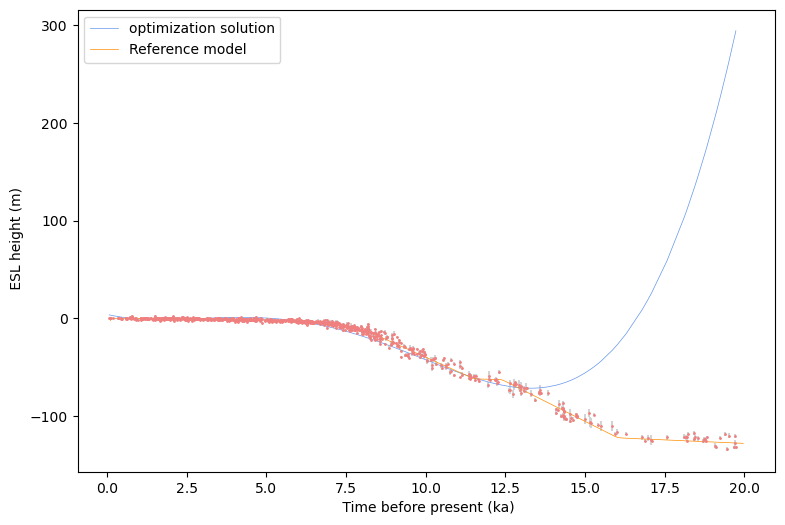

In [24]:
plot_data()
plot_model(data_x,jacobian(data_x).dot(inv_result_2.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

The optimization fails to convergence for this problem (with default settings). 

-------

### Challenge - Change the polynomial degree

Try and replace the 3rd order polynomial with a 2nd order polynomial (i.e. $M=2$) by adding the required commands below. What does the plot looks like? 

Start from code below:

```
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=<CHANGE ME>))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = <CHANGE ME> ")
plot_data()
plot_model(data_x,jacobian(x,n=<CHANGE ME>).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

```


In [25]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 3 


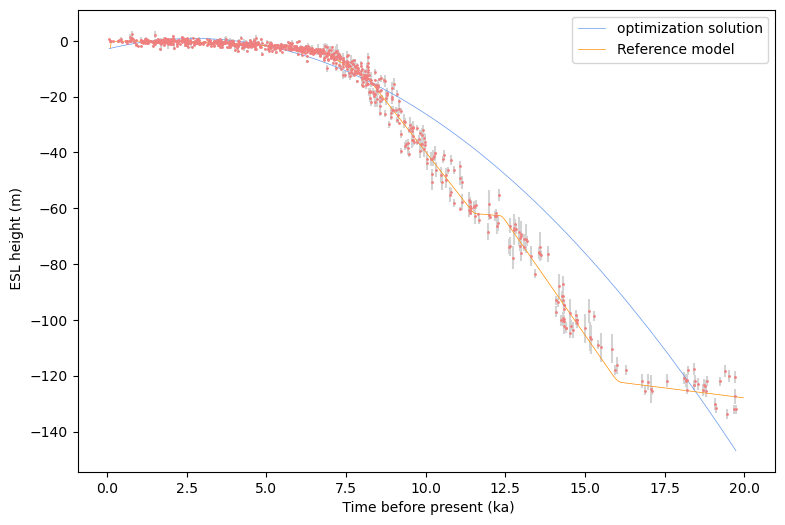

In [26]:
#@title Solution

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=3))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = 3 ")
plot_data()
plot_model(data_x,jacobian(data_x,n=3).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

Changing to a second order polynomial does converge but gives a poor fit.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

Here we artificially increase the observational errors on the data so that the spread of the posterior samples are visible.

In [27]:
Cdinv = Cd_inv()                 # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [28]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [29]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Add the information and run with CoFI

In [30]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## CoFI InversionOptions - get a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True, initial_state=walkers_start)

######## CoFI Inversion - run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

  0%|                                                                                                                                                                                                                                                                  | 0/10000 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                                                                                                       | 14/10000 [00:00<01:15, 131.87it/s]

  0%|▋                                                                                                                                                                                                                                                       | 28/10000 [00:00<01:21, 122.50it/s]

  0%|█                                                                                                                                                                                                                                                       | 42/10000 [00:00<01:17, 128.38it/s]

  1%|█▍                                                                                                                                                                                                                                                      | 56/10000 [00:00<01:15, 131.52it/s]

  1%|█▋                                                                                                                                                                                                                                                      | 70/10000 [00:00<01:14, 133.39it/s]

  1%|██                                                                                                                                                                                                                                                      | 84/10000 [00:00<01:13, 134.46it/s]

  1%|██▍                                                                                                                                                                                                                                                     | 98/10000 [00:00<01:14, 132.89it/s]

  1%|██▊                                                                                                                                                                                                                                                    | 112/10000 [00:00<01:16, 129.55it/s]

  1%|███                                                                                                                                                                                                                                                    | 126/10000 [00:00<01:14, 131.79it/s]

  1%|███▍                                                                                                                                                                                                                                                   | 140/10000 [00:01<01:25, 114.67it/s]

  2%|███▊                                                                                                                                                                                                                                                   | 154/10000 [00:01<01:22, 119.27it/s]

  2%|████▏                                                                                                                                                                                                                                                  | 168/10000 [00:01<01:19, 124.05it/s]

  2%|████▍                                                                                                                                                                                                                                                  | 182/10000 [00:01<01:16, 127.55it/s]

  2%|████▊                                                                                                                                                                                                                                                  | 196/10000 [00:01<01:15, 130.20it/s]

  2%|█████▏                                                                                                                                                                                                                                                 | 210/10000 [00:01<01:14, 132.02it/s]

  2%|█████▌                                                                                                                                                                                                                                                 | 224/10000 [00:01<01:13, 133.38it/s]

  2%|█████▉                                                                                                                                                                                                                                                 | 238/10000 [00:01<01:13, 132.65it/s]

  3%|██████▏                                                                                                                                                                                                                                                | 252/10000 [00:01<01:12, 133.75it/s]

  3%|██████▌                                                                                                                                                                                                                                                | 266/10000 [00:02<01:12, 134.58it/s]

  3%|██████▉                                                                                                                                                                                                                                                | 280/10000 [00:02<01:13, 131.44it/s]

  3%|███████▎                                                                                                                                                                                                                                               | 294/10000 [00:02<01:20, 120.28it/s]

  3%|███████▌                                                                                                                                                                                                                                               | 307/10000 [00:02<01:24, 115.30it/s]

  3%|███████▉                                                                                                                                                                                                                                               | 321/10000 [00:02<01:20, 120.89it/s]

  3%|████████▎                                                                                                                                                                                                                                              | 335/10000 [00:02<01:17, 125.09it/s]

  3%|████████▌                                                                                                                                                                                                                                              | 349/10000 [00:02<01:15, 128.45it/s]

  4%|████████▉                                                                                                                                                                                                                                              | 363/10000 [00:02<01:13, 130.83it/s]

  4%|█████████▎                                                                                                                                                                                                                                             | 377/10000 [00:02<01:13, 131.79it/s]

  4%|█████████▋                                                                                                                                                                                                                                             | 391/10000 [00:03<01:12, 133.27it/s]

  4%|██████████                                                                                                                                                                                                                                             | 405/10000 [00:03<01:11, 134.06it/s]

  4%|██████████▎                                                                                                                                                                                                                                            | 419/10000 [00:03<01:11, 134.69it/s]

  4%|██████████▋                                                                                                                                                                                                                                            | 433/10000 [00:03<01:10, 135.11it/s]

  4%|███████████                                                                                                                                                                                                                                            | 447/10000 [00:03<01:13, 130.04it/s]

  5%|███████████▍                                                                                                                                                                                                                                           | 461/10000 [00:03<01:12, 131.91it/s]

  5%|███████████▋                                                                                                                                                                                                                                           | 475/10000 [00:03<01:11, 132.35it/s]

  5%|████████████                                                                                                                                                                                                                                           | 489/10000 [00:03<01:12, 131.68it/s]

  5%|████████████▍                                                                                                                                                                                                                                          | 503/10000 [00:03<01:11, 133.11it/s]

  5%|████████████▊                                                                                                                                                                                                                                          | 517/10000 [00:03<01:10, 134.08it/s]

  5%|█████████████                                                                                                                                                                                                                                          | 531/10000 [00:04<01:10, 134.77it/s]

  5%|█████████████▍                                                                                                                                                                                                                                         | 545/10000 [00:04<01:10, 134.90it/s]

  6%|█████████████▊                                                                                                                                                                                                                                         | 559/10000 [00:04<01:09, 135.33it/s]

  6%|██████████████▏                                                                                                                                                                                                                                        | 573/10000 [00:04<01:09, 135.77it/s]

  6%|██████████████▍                                                                                                                                                                                                                                        | 587/10000 [00:04<01:09, 136.15it/s]

  6%|██████████████▊                                                                                                                                                                                                                                        | 601/10000 [00:04<01:08, 136.37it/s]

  6%|███████████████▏                                                                                                                                                                                                                                       | 615/10000 [00:04<01:08, 136.08it/s]

  6%|███████████████▌                                                                                                                                                                                                                                       | 629/10000 [00:04<01:10, 133.80it/s]

  6%|███████████████▉                                                                                                                                                                                                                                       | 643/10000 [00:04<01:09, 134.21it/s]

  7%|████████████████▏                                                                                                                                                                                                                                      | 657/10000 [00:05<01:19, 117.37it/s]

  7%|████████████████▌                                                                                                                                                                                                                                      | 671/10000 [00:05<01:16, 122.01it/s]

  7%|████████████████▉                                                                                                                                                                                                                                      | 685/10000 [00:05<01:14, 125.75it/s]

  7%|█████████████████▎                                                                                                                                                                                                                                     | 699/10000 [00:05<01:17, 119.33it/s]

  7%|█████████████████▌                                                                                                                                                                                                                                     | 713/10000 [00:05<01:15, 123.80it/s]

  7%|█████████████████▉                                                                                                                                                                                                                                     | 726/10000 [00:05<01:14, 123.77it/s]

  7%|██████████████████▎                                                                                                                                                                                                                                    | 740/10000 [00:05<01:12, 127.22it/s]

  8%|██████████████████▌                                                                                                                                                                                                                                    | 753/10000 [00:05<01:19, 116.52it/s]

  8%|██████████████████▉                                                                                                                                                                                                                                    | 765/10000 [00:05<01:19, 116.53it/s]

  8%|███████████████████▏                                                                                                                                                                                                                                   | 778/10000 [00:06<01:16, 119.88it/s]

  8%|███████████████████▌                                                                                                                                                                                                                                   | 792/10000 [00:06<01:14, 124.26it/s]

  8%|███████████████████▉                                                                                                                                                                                                                                   | 806/10000 [00:06<01:12, 127.00it/s]

  8%|████████████████████▎                                                                                                                                                                                                                                  | 820/10000 [00:06<01:11, 129.26it/s]

  8%|████████████████████▌                                                                                                                                                                                                                                  | 833/10000 [00:06<01:18, 117.32it/s]

  8%|████████████████████▉                                                                                                                                                                                                                                  | 847/10000 [00:06<01:14, 122.48it/s]

  9%|█████████████████████▎                                                                                                                                                                                                                                 | 861/10000 [00:06<01:13, 124.45it/s]

  9%|█████████████████████▌                                                                                                                                                                                                                                 | 875/10000 [00:06<01:11, 127.66it/s]

  9%|█████████████████████▉                                                                                                                                                                                                                                 | 888/10000 [00:06<01:17, 117.57it/s]

  9%|██████████████████████▏                                                                                                                                                                                                                                | 900/10000 [00:07<01:25, 106.49it/s]

  9%|██████████████████████▌                                                                                                                                                                                                                                | 911/10000 [00:07<01:28, 102.72it/s]

  9%|██████████████████████▊                                                                                                                                                                                                                                | 922/10000 [00:07<01:26, 104.40it/s]

  9%|███████████████████████                                                                                                                                                                                                                                | 936/10000 [00:07<01:20, 113.04it/s]

 10%|███████████████████████▍                                                                                                                                                                                                                               | 950/10000 [00:07<01:15, 119.37it/s]

 10%|███████████████████████▊                                                                                                                                                                                                                               | 964/10000 [00:07<01:12, 123.94it/s]

 10%|████████████████████████▏                                                                                                                                                                                                                              | 978/10000 [00:07<01:10, 127.62it/s]

 10%|████████████████████████▌                                                                                                                                                                                                                              | 992/10000 [00:07<01:09, 130.22it/s]

 10%|████████████████████████▋                                                                                                                                                                                                                             | 1006/10000 [00:07<01:08, 131.38it/s]

 10%|█████████████████████████                                                                                                                                                                                                                             | 1020/10000 [00:08<01:16, 117.84it/s]

 10%|█████████████████████████▍                                                                                                                                                                                                                            | 1033/10000 [00:08<01:18, 114.93it/s]

 10%|█████████████████████████▋                                                                                                                                                                                                                            | 1045/10000 [00:08<01:28, 100.75it/s]

 11%|██████████████████████████                                                                                                                                                                                                                            | 1059/10000 [00:08<01:21, 109.67it/s]

 11%|██████████████████████████▍                                                                                                                                                                                                                           | 1073/10000 [00:08<01:16, 116.74it/s]

 11%|██████████████████████████▋                                                                                                                                                                                                                           | 1087/10000 [00:08<01:12, 122.13it/s]

 11%|███████████████████████████                                                                                                                                                                                                                           | 1101/10000 [00:08<01:10, 125.80it/s]

 11%|███████████████████████████▍                                                                                                                                                                                                                          | 1115/10000 [00:08<01:09, 128.65it/s]

 11%|███████████████████████████▊                                                                                                                                                                                                                          | 1129/10000 [00:08<01:07, 131.02it/s]

 11%|████████████████████████████                                                                                                                                                                                                                          | 1143/10000 [00:09<01:06, 132.41it/s]

 12%|████████████████████████████▍                                                                                                                                                                                                                         | 1157/10000 [00:09<01:06, 133.47it/s]

 12%|████████████████████████████▊                                                                                                                                                                                                                         | 1171/10000 [00:09<01:06, 132.98it/s]

 12%|█████████████████████████████▏                                                                                                                                                                                                                        | 1185/10000 [00:09<01:07, 131.48it/s]

 12%|█████████████████████████████▍                                                                                                                                                                                                                        | 1199/10000 [00:09<01:06, 132.43it/s]

 12%|█████████████████████████████▊                                                                                                                                                                                                                        | 1213/10000 [00:09<01:05, 133.55it/s]

 12%|██████████████████████████████▏                                                                                                                                                                                                                       | 1227/10000 [00:09<01:05, 134.43it/s]

 12%|██████████████████████████████▌                                                                                                                                                                                                                       | 1241/10000 [00:09<01:05, 133.18it/s]

 13%|██████████████████████████████▊                                                                                                                                                                                                                       | 1255/10000 [00:09<01:05, 134.02it/s]

 13%|███████████████████████████████▏                                                                                                                                                                                                                      | 1269/10000 [00:10<01:04, 134.62it/s]

 13%|███████████████████████████████▌                                                                                                                                                                                                                      | 1283/10000 [00:10<01:05, 133.82it/s]

 13%|███████████████████████████████▉                                                                                                                                                                                                                      | 1297/10000 [00:10<01:04, 134.41it/s]

 13%|████████████████████████████████▎                                                                                                                                                                                                                     | 1311/10000 [00:10<01:04, 134.86it/s]

 13%|████████████████████████████████▌                                                                                                                                                                                                                     | 1325/10000 [00:10<01:04, 135.29it/s]

 13%|████████████████████████████████▉                                                                                                                                                                                                                     | 1339/10000 [00:10<01:03, 135.61it/s]

 14%|█████████████████████████████████▎                                                                                                                                                                                                                    | 1353/10000 [00:10<01:03, 135.82it/s]

 14%|█████████████████████████████████▋                                                                                                                                                                                                                    | 1367/10000 [00:10<01:03, 135.55it/s]

 14%|█████████████████████████████████▉                                                                                                                                                                                                                    | 1381/10000 [00:10<01:03, 135.87it/s]

 14%|██████████████████████████████████▎                                                                                                                                                                                                                   | 1395/10000 [00:10<01:03, 135.97it/s]

 14%|██████████████████████████████████▋                                                                                                                                                                                                                   | 1409/10000 [00:11<01:03, 135.98it/s]

 14%|███████████████████████████████████                                                                                                                                                                                                                   | 1423/10000 [00:11<01:03, 136.13it/s]

 14%|███████████████████████████████████▎                                                                                                                                                                                                                  | 1437/10000 [00:11<01:02, 136.26it/s]

 15%|███████████████████████████████████▋                                                                                                                                                                                                                  | 1451/10000 [00:11<01:02, 136.36it/s]

 15%|████████████████████████████████████                                                                                                                                                                                                                  | 1465/10000 [00:11<01:02, 136.41it/s]

 15%|████████████████████████████████████▍                                                                                                                                                                                                                 | 1479/10000 [00:11<01:02, 136.46it/s]

 15%|████████████████████████████████████▋                                                                                                                                                                                                                 | 1493/10000 [00:11<01:02, 136.67it/s]

 15%|█████████████████████████████████████                                                                                                                                                                                                                 | 1507/10000 [00:11<01:02, 136.59it/s]

 15%|█████████████████████████████████████▍                                                                                                                                                                                                                | 1521/10000 [00:11<01:02, 136.72it/s]

 15%|█████████████████████████████████████▊                                                                                                                                                                                                                | 1535/10000 [00:11<01:02, 136.16it/s]

 15%|██████████████████████████████████████                                                                                                                                                                                                                | 1549/10000 [00:12<01:02, 136.24it/s]

 16%|██████████████████████████████████████▍                                                                                                                                                                                                               | 1563/10000 [00:12<01:02, 135.95it/s]

 16%|██████████████████████████████████████▊                                                                                                                                                                                                               | 1577/10000 [00:12<01:01, 136.08it/s]

 16%|███████████████████████████████████████▏                                                                                                                                                                                                              | 1591/10000 [00:12<01:01, 136.26it/s]

 16%|███████████████████████████████████████▍                                                                                                                                                                                                              | 1605/10000 [00:12<01:01, 136.42it/s]

 16%|███████████████████████████████████████▊                                                                                                                                                                                                              | 1619/10000 [00:12<01:01, 136.44it/s]

 16%|████████████████████████████████████████▏                                                                                                                                                                                                             | 1633/10000 [00:12<01:01, 136.23it/s]

 16%|████████████████████████████████████████▌                                                                                                                                                                                                             | 1647/10000 [00:12<01:02, 133.51it/s]

 17%|████████████████████████████████████████▊                                                                                                                                                                                                             | 1661/10000 [00:12<01:02, 133.06it/s]

 17%|█████████████████████████████████████████▏                                                                                                                                                                                                            | 1675/10000 [00:13<01:10, 117.29it/s]

 17%|█████████████████████████████████████████▌                                                                                                                                                                                                            | 1689/10000 [00:13<01:08, 121.94it/s]

 17%|█████████████████████████████████████████▉                                                                                                                                                                                                            | 1703/10000 [00:13<01:05, 125.75it/s]

 17%|██████████████████████████████████████████▏                                                                                                                                                                                                           | 1717/10000 [00:13<01:04, 128.73it/s]

 17%|██████████████████████████████████████████▌                                                                                                                                                                                                           | 1731/10000 [00:13<01:08, 121.48it/s]

 17%|██████████████████████████████████████████▉                                                                                                                                                                                                           | 1744/10000 [00:13<01:07, 122.34it/s]

 18%|███████████████████████████████████████████▏                                                                                                                                                                                                          | 1758/10000 [00:13<01:05, 126.30it/s]

 18%|███████████████████████████████████████████▌                                                                                                                                                                                                          | 1771/10000 [00:13<01:11, 114.78it/s]

 18%|███████████████████████████████████████████▊                                                                                                                                                                                                          | 1783/10000 [00:13<01:15, 108.96it/s]

 18%|████████████████████████████████████████████▏                                                                                                                                                                                                         | 1795/10000 [00:14<01:21, 100.88it/s]

 18%|████████████████████████████████████████████▍                                                                                                                                                                                                         | 1807/10000 [00:14<01:17, 105.22it/s]

 18%|████████████████████████████████████████████▊                                                                                                                                                                                                         | 1821/10000 [00:14<01:12, 113.56it/s]

 18%|█████████████████████████████████████████████▏                                                                                                                                                                                                        | 1835/10000 [00:14<01:08, 120.06it/s]

 18%|█████████████████████████████████████████████▍                                                                                                                                                                                                        | 1849/10000 [00:14<01:05, 124.69it/s]

 19%|█████████████████████████████████████████████▊                                                                                                                                                                                                        | 1863/10000 [00:14<01:03, 128.21it/s]

 19%|██████████████████████████████████████████████▏                                                                                                                                                                                                       | 1877/10000 [00:14<01:02, 130.12it/s]

 19%|██████████████████████████████████████████████▌                                                                                                                                                                                                       | 1891/10000 [00:14<01:01, 132.12it/s]

 19%|██████████████████████████████████████████████▊                                                                                                                                                                                                       | 1905/10000 [00:14<01:00, 133.49it/s]

 19%|███████████████████████████████████████████████▏                                                                                                                                                                                                      | 1919/10000 [00:15<01:00, 134.13it/s]

 19%|███████████████████████████████████████████████▌                                                                                                                                                                                                      | 1933/10000 [00:15<00:59, 134.56it/s]

 19%|███████████████████████████████████████████████▉                                                                                                                                                                                                      | 1947/10000 [00:15<00:59, 134.37it/s]

 20%|████████████████████████████████████████████████▏                                                                                                                                                                                                     | 1961/10000 [00:15<00:59, 134.82it/s]

 20%|████████████████████████████████████████████████▌                                                                                                                                                                                                     | 1975/10000 [00:15<00:59, 135.04it/s]

 20%|████████████████████████████████████████████████▉                                                                                                                                                                                                     | 1989/10000 [00:15<00:59, 134.34it/s]

 20%|█████████████████████████████████████████████████▎                                                                                                                                                                                                    | 2003/10000 [00:15<00:59, 134.76it/s]

 20%|█████████████████████████████████████████████████▌                                                                                                                                                                                                    | 2017/10000 [00:15<01:17, 103.62it/s]

 20%|█████████████████████████████████████████████████▉                                                                                                                                                                                                    | 2029/10000 [00:15<01:18, 101.70it/s]

 20%|██████████████████████████████████████████████████▍                                                                                                                                                                                                    | 2040/10000 [00:16<01:26, 91.50it/s]

 21%|██████████████████████████████████████████████████▋                                                                                                                                                                                                    | 2051/10000 [00:16<01:25, 93.31it/s]

 21%|██████████████████████████████████████████████████▉                                                                                                                                                                                                    | 2061/10000 [00:16<01:23, 94.84it/s]

 21%|███████████████████████████████████████████████████▏                                                                                                                                                                                                   | 2073/10000 [00:16<01:19, 99.72it/s]

 21%|███████████████████████████████████████████████████▎                                                                                                                                                                                                  | 2087/10000 [00:16<01:11, 109.96it/s]

 21%|███████████████████████████████████████████████████▋                                                                                                                                                                                                  | 2101/10000 [00:16<01:07, 117.51it/s]

 21%|████████████████████████████████████████████████████                                                                                                                                                                                                  | 2115/10000 [00:16<01:04, 122.67it/s]

 21%|████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 2129/10000 [00:16<01:02, 126.09it/s]

 21%|████████████████████████████████████████████████████▋                                                                                                                                                                                                 | 2143/10000 [00:16<01:00, 129.24it/s]

 22%|█████████████████████████████████████████████████████                                                                                                                                                                                                 | 2157/10000 [00:17<00:59, 131.54it/s]

 22%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                | 2171/10000 [00:17<00:58, 133.10it/s]

 22%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                | 2185/10000 [00:17<00:58, 134.07it/s]

 22%|██████████████████████████████████████████████████████                                                                                                                                                                                                | 2199/10000 [00:17<00:57, 134.86it/s]

 22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                               | 2213/10000 [00:17<00:57, 135.47it/s]

 22%|██████████████████████████████████████████████████████▊                                                                                                                                                                                               | 2227/10000 [00:17<00:57, 135.42it/s]

 22%|███████████████████████████████████████████████████████▏                                                                                                                                                                                              | 2241/10000 [00:17<00:57, 135.81it/s]

 23%|███████████████████████████████████████████████████████▍                                                                                                                                                                                              | 2255/10000 [00:17<00:57, 134.10it/s]

 23%|███████████████████████████████████████████████████████▊                                                                                                                                                                                              | 2269/10000 [00:17<01:07, 114.42it/s]

 23%|████████████████████████████████████████████████████████                                                                                                                                                                                              | 2281/10000 [00:18<01:12, 106.42it/s]

 23%|████████████████████████████████████████████████████████▋                                                                                                                                                                                              | 2293/10000 [00:18<01:20, 95.18it/s]

 23%|████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 2304/10000 [00:18<01:18, 97.55it/s]

 23%|████████████████████████████████████████████████████████▉                                                                                                                                                                                             | 2316/10000 [00:18<01:15, 102.26it/s]

 23%|█████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 2327/10000 [00:18<01:23, 92.28it/s]

 23%|█████████████████████████████████████████████████████████▌                                                                                                                                                                                            | 2340/10000 [00:18<01:15, 101.60it/s]

 24%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                            | 2354/10000 [00:18<01:09, 110.70it/s]

 24%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 2368/10000 [00:18<01:04, 117.64it/s]

 24%|██████████████████████████████████████████████████████████▌                                                                                                                                                                                           | 2382/10000 [00:19<01:02, 122.78it/s]

 24%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 2396/10000 [00:19<01:00, 126.69it/s]

 24%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 2410/10000 [00:19<00:58, 129.70it/s]

 24%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                          | 2424/10000 [00:19<00:57, 130.91it/s]

 24%|███████████████████████████████████████████████████████████▉                                                                                                                                                                                          | 2438/10000 [00:19<00:57, 132.59it/s]

 25%|████████████████████████████████████████████████████████████▎                                                                                                                                                                                         | 2452/10000 [00:19<00:56, 133.26it/s]

 25%|████████████████████████████████████████████████████████████▋                                                                                                                                                                                         | 2466/10000 [00:19<00:56, 132.46it/s]

 25%|█████████████████████████████████████████████████████████████                                                                                                                                                                                         | 2480/10000 [00:19<00:56, 133.48it/s]

 25%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 2494/10000 [00:19<00:58, 127.75it/s]

 25%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                        | 2508/10000 [00:19<00:57, 130.44it/s]

 25%|██████████████████████████████████████████████████████████████                                                                                                                                                                                        | 2522/10000 [00:20<00:56, 132.19it/s]

 25%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                       | 2536/10000 [00:20<00:55, 133.64it/s]

 26%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 2550/10000 [00:20<00:55, 134.81it/s]

 26%|███████████████████████████████████████████████████████████████                                                                                                                                                                                       | 2564/10000 [00:20<00:54, 135.23it/s]

 26%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                                      | 2578/10000 [00:20<00:54, 135.85it/s]

 26%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 2592/10000 [00:20<00:54, 136.28it/s]

 26%|████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 2606/10000 [00:20<00:54, 136.76it/s]

 26%|████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 2620/10000 [00:20<00:53, 137.07it/s]

 26%|████████████████████████████████████████████████████████████████▊                                                                                                                                                                                     | 2634/10000 [00:20<00:53, 137.21it/s]

 26%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 2648/10000 [00:21<00:53, 137.29it/s]

 27%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 2662/10000 [00:21<00:53, 137.25it/s]

 27%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 2676/10000 [00:21<00:53, 137.34it/s]

 27%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 2690/10000 [00:21<00:53, 137.27it/s]

 27%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 2704/10000 [00:21<00:53, 137.43it/s]

 27%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 2718/10000 [00:21<00:52, 137.45it/s]

 27%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 2732/10000 [00:21<00:52, 137.56it/s]

 27%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 2746/10000 [00:21<00:53, 135.38it/s]

 28%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 2760/10000 [00:21<00:53, 135.75it/s]

 28%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 2774/10000 [00:21<00:53, 136.32it/s]

 28%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 2788/10000 [00:22<00:52, 136.33it/s]

 28%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                 | 2802/10000 [00:22<00:52, 136.43it/s]

 28%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                | 2816/10000 [00:22<00:52, 136.76it/s]

 28%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                | 2830/10000 [00:22<00:52, 136.91it/s]

 28%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 2844/10000 [00:22<00:52, 136.84it/s]

 29%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 2858/10000 [00:22<00:52, 136.68it/s]

 29%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 2872/10000 [00:22<00:52, 136.37it/s]

 29%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 2886/10000 [00:22<00:52, 136.33it/s]

 29%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 2900/10000 [00:22<00:52, 135.87it/s]

 29%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 2914/10000 [00:22<00:52, 135.19it/s]

 29%|████████████████████████████████████████████████████████████████████████                                                                                                                                                                              | 2928/10000 [00:23<01:02, 112.94it/s]

 29%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 2942/10000 [00:23<00:59, 118.60it/s]

 30%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 2956/10000 [00:23<00:57, 123.03it/s]

 30%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 2970/10000 [00:23<00:55, 126.73it/s]

 30%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 2984/10000 [00:23<00:54, 129.15it/s]

 30%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 2998/10000 [00:23<00:53, 130.89it/s]

 30%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 3012/10000 [00:23<00:53, 131.37it/s]

 30%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 3026/10000 [00:23<00:52, 132.25it/s]

 30%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                           | 3040/10000 [00:23<00:52, 133.10it/s]

 31%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 3054/10000 [00:24<01:01, 112.82it/s]

 31%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                          | 3068/10000 [00:24<00:58, 118.52it/s]

 31%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 3082/10000 [00:24<00:56, 122.85it/s]

 31%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 3096/10000 [00:24<00:54, 126.09it/s]

 31%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                         | 3110/10000 [00:24<00:53, 128.45it/s]

 31%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 3124/10000 [00:24<00:52, 130.13it/s]

 31%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 3138/10000 [00:24<00:52, 129.61it/s]

 32%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 3152/10000 [00:24<00:52, 131.09it/s]

 32%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                        | 3166/10000 [00:24<00:51, 132.39it/s]

 32%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                       | 3180/10000 [00:25<00:51, 133.53it/s]

 32%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 3194/10000 [00:25<00:51, 132.98it/s]

 32%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 3208/10000 [00:25<00:50, 133.83it/s]

 32%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 3222/10000 [00:25<00:50, 134.53it/s]

 32%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                      | 3236/10000 [00:25<00:50, 134.80it/s]

 32%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 3250/10000 [00:25<00:49, 135.14it/s]

 33%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 3264/10000 [00:25<00:49, 135.40it/s]

 33%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 3278/10000 [00:25<00:49, 135.49it/s]

 33%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 3292/10000 [00:25<00:49, 135.58it/s]

 33%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                    | 3306/10000 [00:25<00:49, 135.73it/s]

 33%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 3320/10000 [00:26<00:49, 135.20it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                    | 3334/10000 [00:26<00:51, 130.32it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 3348/10000 [00:26<00:57, 115.02it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 3360/10000 [00:26<01:07, 97.67it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 3374/10000 [00:26<01:01, 106.98it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                  | 3386/10000 [00:26<01:03, 103.58it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 3400/10000 [00:26<00:58, 111.93it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 3414/10000 [00:26<00:55, 118.33it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 3428/10000 [00:27<00:53, 123.16it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 3442/10000 [00:27<00:51, 126.68it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                 | 3456/10000 [00:27<00:50, 129.16it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 3470/10000 [00:27<00:49, 130.99it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 3484/10000 [00:27<00:49, 132.36it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                | 3498/10000 [00:27<00:49, 132.34it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                               | 3512/10000 [00:27<00:48, 133.89it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 3526/10000 [00:27<00:48, 133.00it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 3540/10000 [00:27<00:48, 133.38it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 3554/10000 [00:28<00:49, 129.36it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 3567/10000 [00:28<00:54, 118.64it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 3580/10000 [00:28<00:58, 110.31it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 3592/10000 [00:28<01:00, 105.56it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 3603/10000 [00:28<01:09, 92.07it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 3615/10000 [00:28<01:05, 98.13it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 3629/10000 [00:28<00:58, 108.08it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 3643/10000 [00:28<00:54, 115.81it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 3657/10000 [00:29<00:52, 121.67it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 3671/10000 [00:29<00:50, 125.97it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 3685/10000 [00:29<00:48, 129.12it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 3699/10000 [00:29<00:48, 130.35it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 3713/10000 [00:29<00:47, 132.13it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 3727/10000 [00:29<00:47, 132.49it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 3741/10000 [00:29<00:46, 133.62it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 3755/10000 [00:29<00:46, 133.08it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 3769/10000 [00:29<00:46, 134.11it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 3783/10000 [00:30<01:03, 98.48it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 3795/10000 [00:30<01:09, 89.48it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 3806/10000 [00:30<01:12, 85.31it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 3816/10000 [00:30<01:14, 83.51it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 3825/10000 [00:30<01:16, 80.97it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 3834/10000 [00:30<01:16, 80.95it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 3843/10000 [00:30<01:17, 79.83it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 3852/10000 [00:30<01:19, 76.92it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 3860/10000 [00:31<01:21, 74.93it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 3874/10000 [00:31<01:07, 90.32it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 3888/10000 [00:31<00:59, 102.64it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 3902/10000 [00:31<00:54, 111.87it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 3916/10000 [00:31<00:51, 118.71it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 3929/10000 [00:31<00:59, 102.48it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 3943/10000 [00:31<00:54, 110.85it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 3957/10000 [00:31<00:51, 117.44it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 3971/10000 [00:31<00:49, 122.51it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 3985/10000 [00:32<00:47, 126.18it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 3999/10000 [00:32<00:46, 128.88it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 4013/10000 [00:32<00:45, 130.80it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 4027/10000 [00:32<00:45, 132.23it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 4041/10000 [00:32<00:44, 133.16it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 4055/10000 [00:32<00:47, 124.33it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 4068/10000 [00:32<00:50, 117.75it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 4080/10000 [00:32<00:52, 111.99it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 4094/10000 [00:32<00:49, 118.20it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 4106/10000 [00:33<00:53, 110.03it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 4120/10000 [00:33<00:50, 116.56it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 4134/10000 [00:33<00:48, 121.65it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 4148/10000 [00:33<00:46, 125.61it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 4162/10000 [00:33<00:45, 128.55it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 4176/10000 [00:33<00:44, 130.58it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 4190/10000 [00:33<00:44, 130.29it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 4204/10000 [00:33<00:43, 131.86it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 4218/10000 [00:33<00:43, 133.12it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 4232/10000 [00:34<00:43, 133.86it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 4246/10000 [00:34<00:43, 133.18it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 4260/10000 [00:34<00:42, 134.01it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 4274/10000 [00:34<00:42, 134.53it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 4288/10000 [00:34<00:42, 134.93it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 4302/10000 [00:34<00:42, 135.16it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 4316/10000 [00:34<00:42, 135.28it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 4330/10000 [00:34<00:41, 135.12it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 4344/10000 [00:34<00:41, 135.18it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 4358/10000 [00:34<00:41, 135.37it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 4372/10000 [00:35<00:41, 135.52it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 4386/10000 [00:35<00:41, 135.28it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 4400/10000 [00:35<00:41, 135.43it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 4414/10000 [00:35<00:51, 109.52it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 4426/10000 [00:35<00:52, 106.05it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 4440/10000 [00:35<00:48, 113.67it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 4454/10000 [00:35<00:46, 119.59it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 4468/10000 [00:35<00:44, 124.07it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 4482/10000 [00:36<00:43, 127.37it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 4496/10000 [00:36<00:42, 129.63it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 4510/10000 [00:36<00:41, 130.91it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 4524/10000 [00:36<00:41, 131.87it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 4538/10000 [00:36<00:41, 132.77it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 4552/10000 [00:36<00:40, 133.56it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 4566/10000 [00:36<00:40, 134.03it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 4580/10000 [00:36<00:40, 132.44it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 4594/10000 [00:36<00:40, 133.30it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 4608/10000 [00:36<00:40, 133.93it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 4622/10000 [00:37<00:39, 134.46it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 4636/10000 [00:37<00:39, 134.84it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 4650/10000 [00:37<00:39, 135.02it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 4664/10000 [00:37<00:39, 135.29it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 4678/10000 [00:37<00:41, 129.61it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 4692/10000 [00:37<00:40, 131.44it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 4706/10000 [00:37<00:39, 132.71it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 4720/10000 [00:37<00:39, 132.17it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 4734/10000 [00:37<00:39, 132.40it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 4748/10000 [00:38<00:39, 133.41it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 4762/10000 [00:38<00:44, 117.76it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 4776/10000 [00:38<00:42, 122.56it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 4789/10000 [00:38<00:44, 118.26it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 4803/10000 [00:38<00:42, 123.29it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 4817/10000 [00:38<00:40, 127.11it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 4831/10000 [00:38<00:39, 129.62it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 4845/10000 [00:38<00:39, 131.66it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 4859/10000 [00:38<00:38, 132.77it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 4873/10000 [00:38<00:38, 133.90it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 4887/10000 [00:39<00:37, 134.56it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 4901/10000 [00:39<00:38, 133.57it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 4915/10000 [00:39<00:38, 133.73it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 4929/10000 [00:39<00:37, 134.56it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 4943/10000 [00:39<00:37, 135.12it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 4957/10000 [00:39<00:37, 135.56it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 4971/10000 [00:39<00:37, 134.06it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 4985/10000 [00:39<00:37, 134.76it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 4999/10000 [00:39<00:37, 135.04it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 5013/10000 [00:40<00:36, 135.44it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 5027/10000 [00:40<00:36, 135.11it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 5041/10000 [00:40<00:37, 132.69it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 5055/10000 [00:40<00:37, 132.96it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 5069/10000 [00:40<00:36, 133.53it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 5083/10000 [00:40<00:44, 110.75it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 5096/10000 [00:40<00:43, 113.71it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 5110/10000 [00:40<00:41, 119.22it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 5124/10000 [00:40<00:39, 123.72it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 5137/10000 [00:41<00:39, 123.08it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 5150/10000 [00:41<00:45, 107.06it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 5164/10000 [00:41<00:42, 114.33it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 5178/10000 [00:41<00:40, 120.00it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 5191/10000 [00:41<00:43, 110.80it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 5203/10000 [00:41<00:43, 109.92it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 5215/10000 [00:41<00:53, 89.99it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 5229/10000 [00:41<00:48, 97.51it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 5240/10000 [00:42<00:51, 92.78it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 5254/10000 [00:42<00:46, 102.76it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 5266/10000 [00:42<00:44, 105.30it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 5280/10000 [00:42<00:41, 113.10it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 5292/10000 [00:42<00:44, 105.43it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 5305/10000 [00:42<00:42, 111.70it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 5318/10000 [00:42<00:40, 115.78it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 5332/10000 [00:42<00:38, 120.72it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 5346/10000 [00:42<00:37, 124.92it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 5359/10000 [00:43<00:38, 121.61it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 5373/10000 [00:43<00:36, 125.50it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 5386/10000 [00:43<00:40, 114.57it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 5398/10000 [00:43<00:46, 99.33it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 5409/10000 [00:43<00:49, 92.73it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 5423/10000 [00:43<00:44, 102.60it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 5437/10000 [00:43<00:41, 111.10it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 5451/10000 [00:43<00:38, 117.58it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 5464/10000 [00:44<00:42, 107.47it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 5478/10000 [00:44<00:39, 114.10it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 5490/10000 [00:44<00:40, 111.03it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 5502/10000 [00:44<00:46, 96.50it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 5516/10000 [00:44<00:42, 105.55it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 5530/10000 [00:44<00:39, 112.50it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 5544/10000 [00:44<00:37, 118.10it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 5558/10000 [00:44<00:36, 122.63it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 5571/10000 [00:45<00:39, 112.69it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 5584/10000 [00:45<00:38, 115.47it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 5598/10000 [00:45<00:36, 120.88it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 5612/10000 [00:45<00:35, 124.74it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 5626/10000 [00:45<00:34, 127.57it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 5639/10000 [00:45<00:40, 107.20it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 5652/10000 [00:45<00:38, 112.10it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 5666/10000 [00:45<00:36, 118.17it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 5680/10000 [00:45<00:35, 122.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 5693/10000 [00:46<00:34, 123.06it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 5706/10000 [00:46<00:34, 124.12it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 5720/10000 [00:46<00:33, 127.24it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 5733/10000 [00:46<00:36, 117.69it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 5745/10000 [00:46<00:36, 117.44it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 5759/10000 [00:46<00:34, 122.47it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 5773/10000 [00:46<00:33, 126.21it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 5787/10000 [00:46<00:32, 128.77it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 5800/10000 [00:46<00:37, 111.61it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 5814/10000 [00:47<00:35, 116.92it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 5827/10000 [00:47<00:35, 117.75it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 5840/10000 [00:47<00:40, 103.57it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 5851/10000 [00:47<00:45, 92.17it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 5861/10000 [00:47<00:48, 85.38it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 5870/10000 [00:47<00:50, 81.39it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 5879/10000 [00:47<00:52, 78.84it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 5888/10000 [00:48<01:07, 61.36it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 5895/10000 [00:48<01:14, 55.06it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 5902/10000 [00:48<01:12, 56.81it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 5909/10000 [00:48<01:11, 57.14it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 5916/10000 [00:48<01:08, 59.61it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 5923/10000 [00:48<01:05, 61.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 5930/10000 [00:48<01:04, 63.34it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 5938/10000 [00:48<01:02, 65.38it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 5945/10000 [00:49<01:01, 65.50it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 5953/10000 [00:49<00:58, 69.38it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 5964/10000 [00:49<00:50, 79.86it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 5973/10000 [00:49<00:54, 73.55it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 5981/10000 [00:49<00:56, 71.33it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 5989/10000 [00:49<00:57, 69.66it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 5997/10000 [00:49<01:01, 65.51it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 6004/10000 [00:49<01:01, 65.47it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 6011/10000 [00:49<01:00, 65.93it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 6018/10000 [00:50<00:59, 66.41it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 6025/10000 [00:50<00:59, 66.79it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 6032/10000 [00:50<00:59, 66.53it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 6043/10000 [00:50<00:51, 77.48it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 6056/10000 [00:50<00:43, 91.20it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 6068/10000 [00:50<00:39, 99.16it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 6081/10000 [00:50<00:37, 104.15it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 6092/10000 [00:50<00:42, 90.98it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 6102/10000 [00:51<00:46, 83.23it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 6111/10000 [00:51<00:48, 79.99it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 6120/10000 [00:51<00:52, 73.90it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 6128/10000 [00:51<00:53, 72.39it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 6136/10000 [00:51<00:56, 68.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 6143/10000 [00:51<00:57, 67.32it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 6152/10000 [00:51<00:52, 72.91it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 6164/10000 [00:51<00:45, 84.43it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 6177/10000 [00:51<00:40, 95.21it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 6189/10000 [00:52<00:37, 100.86it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 6202/10000 [00:52<00:35, 107.68it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 6214/10000 [00:52<00:35, 106.42it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 6226/10000 [00:52<00:34, 108.22it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 6239/10000 [00:52<00:32, 114.04it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 6252/10000 [00:52<00:32, 116.41it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 6264/10000 [00:52<00:33, 111.74it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 6276/10000 [00:52<00:35, 106.13it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 6289/10000 [00:52<00:33, 110.93it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 6301/10000 [00:53<00:38, 96.45it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 6312/10000 [00:53<00:41, 87.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 6322/10000 [00:53<00:42, 86.50it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 6331/10000 [00:53<00:48, 75.62it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 6339/10000 [00:53<00:49, 74.48it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 6348/10000 [00:53<00:46, 78.05it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 6357/10000 [00:53<00:46, 77.65it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 6365/10000 [00:54<00:51, 69.96it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 6373/10000 [00:54<00:52, 68.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 6381/10000 [00:54<00:50, 71.36it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 6390/10000 [00:54<00:47, 75.86it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 6403/10000 [00:54<00:40, 89.64it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 6416/10000 [00:54<00:35, 99.71it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 6430/10000 [00:54<00:32, 109.48it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 6443/10000 [00:54<00:31, 113.47it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 6457/10000 [00:54<00:29, 118.97it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 6471/10000 [00:54<00:28, 123.75it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 6485/10000 [00:55<00:27, 127.29it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 6499/10000 [00:55<00:26, 129.70it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 6513/10000 [00:55<00:26, 131.43it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 6527/10000 [00:55<00:26, 132.20it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 6541/10000 [00:55<00:26, 131.94it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 6555/10000 [00:55<00:25, 132.69it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 6569/10000 [00:55<00:25, 133.62it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 6583/10000 [00:55<00:25, 134.27it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 6597/10000 [00:55<00:25, 134.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 6611/10000 [00:56<00:33, 101.53it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 6623/10000 [00:56<00:34, 98.58it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 6636/10000 [00:56<00:31, 105.63it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6650/10000 [00:56<00:29, 113.26it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 6664/10000 [00:56<00:27, 119.47it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 6678/10000 [00:56<00:26, 124.14it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 6692/10000 [00:56<00:25, 127.51it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 6706/10000 [00:56<00:25, 129.69it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 6720/10000 [00:57<00:24, 131.59it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 6734/10000 [00:57<00:24, 132.98it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 6748/10000 [00:57<00:24, 133.68it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 6762/10000 [00:57<00:24, 134.26it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 6776/10000 [00:57<00:23, 134.65it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 6790/10000 [00:57<00:23, 134.96it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 6804/10000 [00:57<00:23, 135.29it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 6818/10000 [00:57<00:23, 133.44it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 6832/10000 [00:57<00:23, 134.01it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6846/10000 [00:57<00:26, 121.11it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6859/10000 [00:58<00:34, 91.67it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 6870/10000 [00:58<00:36, 84.73it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 6881/10000 [00:58<00:34, 89.77it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 6893/10000 [00:58<00:32, 96.01it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 6907/10000 [00:58<00:29, 106.36it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 6921/10000 [00:58<00:26, 114.33it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 6933/10000 [00:58<00:26, 114.45it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 6947/10000 [00:58<00:25, 120.00it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 6961/10000 [00:59<00:24, 124.37it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 6975/10000 [00:59<00:23, 126.28it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 6989/10000 [00:59<00:23, 128.39it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 7003/10000 [00:59<00:22, 130.38it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 7017/10000 [00:59<00:22, 131.91it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 7031/10000 [00:59<00:22, 132.73it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 7045/10000 [00:59<00:22, 133.31it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 7059/10000 [00:59<00:21, 133.95it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 7073/10000 [00:59<00:21, 134.17it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 7087/10000 [01:00<00:25, 114.29it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 7101/10000 [01:00<00:24, 119.17it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 7115/10000 [01:00<00:23, 123.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 7129/10000 [01:00<00:22, 127.14it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 7143/10000 [01:00<00:21, 129.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 7157/10000 [01:00<00:21, 131.78it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 7171/10000 [01:00<00:21, 132.57it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 7185/10000 [01:00<00:21, 128.96it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 7199/10000 [01:00<00:21, 130.91it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 7213/10000 [01:01<00:24, 115.22it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 7225/10000 [01:01<00:26, 105.44it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 7239/10000 [01:01<00:24, 112.30it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 7251/10000 [01:01<00:25, 109.74it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 7265/10000 [01:01<00:23, 117.03it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 7278/10000 [01:01<00:22, 119.23it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 7292/10000 [01:01<00:21, 123.97it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 7305/10000 [01:01<00:21, 125.48it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 7319/10000 [01:01<00:20, 128.36it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 7333/10000 [01:02<00:20, 130.45it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 7347/10000 [01:02<00:20, 132.20it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 7361/10000 [01:02<00:19, 133.36it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 7375/10000 [01:02<00:19, 134.08it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 7389/10000 [01:02<00:19, 134.46it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 7403/10000 [01:02<00:19, 134.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 7417/10000 [01:02<00:19, 135.37it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 7431/10000 [01:02<00:18, 135.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 7445/10000 [01:02<00:19, 133.05it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 7459/10000 [01:02<00:18, 134.21it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 7473/10000 [01:03<00:22, 112.08it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 7487/10000 [01:03<00:21, 118.37it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 7500/10000 [01:03<00:23, 108.39it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 7512/10000 [01:03<00:23, 105.61it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 7525/10000 [01:03<00:22, 110.71it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 7539/10000 [01:03<00:21, 116.26it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 7552/10000 [01:03<00:20, 118.58it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 7565/10000 [01:03<00:20, 116.77it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 7579/10000 [01:04<00:19, 122.38it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 7593/10000 [01:04<00:19, 126.59it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 7607/10000 [01:04<00:18, 129.69it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 7621/10000 [01:04<00:18, 131.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7635/10000 [01:04<00:17, 133.34it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 7649/10000 [01:04<00:17, 134.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 7663/10000 [01:04<00:18, 128.75it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 7677/10000 [01:04<00:17, 130.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 7691/10000 [01:04<00:17, 132.73it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 7705/10000 [01:05<00:17, 134.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 7719/10000 [01:05<00:16, 134.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 7733/10000 [01:05<00:16, 135.47it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 7747/10000 [01:05<00:16, 136.03it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 7761/10000 [01:05<00:16, 136.39it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 7775/10000 [01:05<00:16, 136.56it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 7789/10000 [01:05<00:16, 136.63it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 7803/10000 [01:05<00:16, 136.58it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 7817/10000 [01:05<00:15, 136.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 7831/10000 [01:05<00:15, 136.35it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7845/10000 [01:06<00:15, 136.32it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 7859/10000 [01:06<00:15, 136.08it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 7873/10000 [01:06<00:15, 136.36it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 7887/10000 [01:06<00:15, 136.17it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 7901/10000 [01:06<00:15, 135.75it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 7915/10000 [01:06<00:16, 123.38it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 7929/10000 [01:06<00:16, 126.60it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 7942/10000 [01:06<00:16, 127.14it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 7956/10000 [01:06<00:15, 129.58it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 7970/10000 [01:06<00:15, 131.35it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 7984/10000 [01:07<00:15, 132.62it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 7998/10000 [01:07<00:14, 133.79it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 8012/10000 [01:07<00:15, 127.42it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 8026/10000 [01:07<00:15, 129.80it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 8040/10000 [01:07<00:14, 131.48it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 8054/10000 [01:07<00:14, 132.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 8068/10000 [01:07<00:14, 133.71it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 8082/10000 [01:07<00:14, 134.31it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 8096/10000 [01:07<00:14, 133.46it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 8110/10000 [01:08<00:14, 133.73it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 8124/10000 [01:08<00:13, 134.28it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 8138/10000 [01:08<00:13, 134.56it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 8152/10000 [01:08<00:13, 134.33it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 8166/10000 [01:08<00:13, 134.70it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 8180/10000 [01:08<00:13, 134.97it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 8194/10000 [01:08<00:13, 135.06it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 8208/10000 [01:08<00:13, 134.93it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 8222/10000 [01:08<00:13, 135.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 8236/10000 [01:08<00:13, 135.38it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 8250/10000 [01:09<00:12, 135.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 8264/10000 [01:09<00:12, 135.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 8278/10000 [01:09<00:12, 135.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 8292/10000 [01:09<00:12, 133.78it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 8306/10000 [01:09<00:12, 134.34it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 8320/10000 [01:09<00:12, 134.51it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 8334/10000 [01:09<00:12, 131.19it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 8348/10000 [01:09<00:12, 130.79it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 8362/10000 [01:09<00:12, 132.06it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 8376/10000 [01:10<00:12, 133.07it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 8390/10000 [01:10<00:12, 133.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 8404/10000 [01:10<00:11, 134.04it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 8418/10000 [01:10<00:11, 134.30it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 8432/10000 [01:10<00:11, 134.29it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 8446/10000 [01:10<00:11, 134.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 8460/10000 [01:10<00:11, 134.65it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 8474/10000 [01:10<00:11, 135.17it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 8488/10000 [01:10<00:11, 135.69it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 8502/10000 [01:10<00:11, 136.02it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 8516/10000 [01:11<00:10, 136.19it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 8530/10000 [01:11<00:10, 136.31it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 8544/10000 [01:11<00:10, 136.39it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8558/10000 [01:11<00:10, 136.41it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 8572/10000 [01:11<00:10, 136.39it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 8586/10000 [01:11<00:10, 133.51it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 8600/10000 [01:11<00:10, 129.94it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 8614/10000 [01:11<00:10, 131.43it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 8628/10000 [01:11<00:10, 132.39it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 8642/10000 [01:12<00:10, 133.07it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 8656/10000 [01:12<00:10, 133.44it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 8670/10000 [01:12<00:09, 133.69it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 8684/10000 [01:12<00:09, 134.00it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 8698/10000 [01:12<00:09, 134.19it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 8712/10000 [01:12<00:09, 134.21it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 8726/10000 [01:12<00:09, 133.81it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 8740/10000 [01:12<00:09, 132.60it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 8754/10000 [01:12<00:09, 132.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 8768/10000 [01:12<00:09, 132.57it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8782/10000 [01:13<00:09, 133.70it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 8796/10000 [01:13<00:08, 134.52it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 8810/10000 [01:13<00:08, 135.32it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8824/10000 [01:13<00:08, 135.73it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8838/10000 [01:13<00:08, 136.13it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8852/10000 [01:13<00:08, 136.24it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8866/10000 [01:13<00:08, 136.29it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8880/10000 [01:13<00:08, 131.18it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8894/10000 [01:13<00:08, 132.79it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8908/10000 [01:13<00:08, 133.96it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8922/10000 [01:14<00:08, 134.30it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8936/10000 [01:14<00:07, 134.98it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8950/10000 [01:14<00:07, 135.25it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8964/10000 [01:14<00:07, 134.37it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8978/10000 [01:14<00:07, 134.93it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8992/10000 [01:14<00:07, 135.42it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 9006/10000 [01:14<00:07, 135.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 9020/10000 [01:14<00:07, 135.72it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 9034/10000 [01:14<00:07, 135.97it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 9048/10000 [01:15<00:06, 136.16it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 9062/10000 [01:15<00:06, 136.20it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 9076/10000 [01:15<00:06, 136.18it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 9090/10000 [01:15<00:06, 136.09it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 9104/10000 [01:15<00:06, 136.14it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 9118/10000 [01:15<00:06, 136.09it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 9132/10000 [01:15<00:06, 136.06it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 9146/10000 [01:15<00:06, 135.26it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 9160/10000 [01:15<00:06, 135.57it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 9174/10000 [01:15<00:06, 135.73it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 9188/10000 [01:16<00:05, 135.90it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 9202/10000 [01:16<00:05, 136.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 9216/10000 [01:16<00:05, 136.22it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 9230/10000 [01:16<00:05, 136.16it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 9244/10000 [01:16<00:05, 136.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 9258/10000 [01:16<00:05, 136.36it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 9272/10000 [01:16<00:05, 136.22it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9286/10000 [01:16<00:05, 136.38it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 9300/10000 [01:16<00:05, 135.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 9314/10000 [01:16<00:05, 135.78it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9328/10000 [01:17<00:04, 135.74it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 9342/10000 [01:17<00:04, 135.70it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 9356/10000 [01:17<00:04, 135.70it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9370/10000 [01:17<00:04, 135.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 9384/10000 [01:17<00:04, 135.64it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9398/10000 [01:17<00:04, 135.59it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9412/10000 [01:17<00:04, 135.61it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9426/10000 [01:17<00:04, 135.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9440/10000 [01:17<00:04, 135.11it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9454/10000 [01:18<00:04, 135.39it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9468/10000 [01:18<00:03, 135.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 9482/10000 [01:18<00:03, 135.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9496/10000 [01:18<00:03, 135.94it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9510/10000 [01:18<00:03, 136.00it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9524/10000 [01:18<00:03, 136.14it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9538/10000 [01:18<00:03, 136.14it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9552/10000 [01:18<00:03, 134.36it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9566/10000 [01:18<00:03, 134.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9580/10000 [01:18<00:03, 135.31it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9594/10000 [01:19<00:02, 135.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9608/10000 [01:19<00:02, 135.72it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9622/10000 [01:19<00:02, 135.83it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9636/10000 [01:19<00:02, 135.20it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9650/10000 [01:19<00:02, 135.45it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9664/10000 [01:19<00:02, 135.68it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9678/10000 [01:19<00:02, 135.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9692/10000 [01:19<00:02, 135.93it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9706/10000 [01:19<00:02, 131.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9720/10000 [01:19<00:02, 132.72it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9734/10000 [01:20<00:01, 133.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9748/10000 [01:20<00:01, 134.56it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9762/10000 [01:20<00:01, 135.24it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9776/10000 [01:20<00:01, 135.50it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9790/10000 [01:20<00:01, 135.61it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9804/10000 [01:20<00:01, 135.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9818/10000 [01:20<00:01, 135.61it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9832/10000 [01:20<00:01, 135.65it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9846/10000 [01:20<00:01, 135.95it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9860/10000 [01:21<00:01, 136.05it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9874/10000 [01:21<00:00, 136.11it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9888/10000 [01:21<00:00, 136.25it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9902/10000 [01:21<00:00, 136.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9916/10000 [01:21<00:00, 136.21it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9930/10000 [01:21<00:00, 136.27it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9944/10000 [01:21<00:00, 136.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9958/10000 [01:21<00:00, 134.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9972/10000 [01:21<00:00, 134.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9986/10000 [01:21<00:00, 135.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:22<00:00, 135.27it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:22<00:00, 121.89it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### Post-sampling analysis

By default the raw sampler resulting object is attached to `cofi`'s inversion result.

Optionally, you can convert that into an `arviz` data structure to have access to
a range of analysis functions. (See more details in [arviz documentation](https://python.arviz.org/en/latest/index.html)).

In [31]:
import arviz as az

labels = ["m0", "m1", "m2","m3","m4"]

sampler = inv_result_3.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
# az_idata = inv_result_3.to_arviz()      # alternatively

In [32]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 0.0002071 0.0001355 ... 0.8246 0.8246
    m1       (chain, draw) float64 0.0001005 2.917e-05 ... -2.442 -2.442
    m2       (chain, draw) float64 3.21e-05 1.882e-05 1.882e-05 ... 1.223 1.223
    m3       (chain, draw) float64 -4.478e-05 -7.46e-05 ... -0.1901 -0.1901
    m4       (chain, draw) float64 0.0001376 3.148e-05 ... 0.005898 0.005898
Attributes:
    created_at:                 2023-04-13T07:32:13.373368
    arviz_version:              0.15.1
    inference_library:          emcee
    inference_library_version:  3.1.4

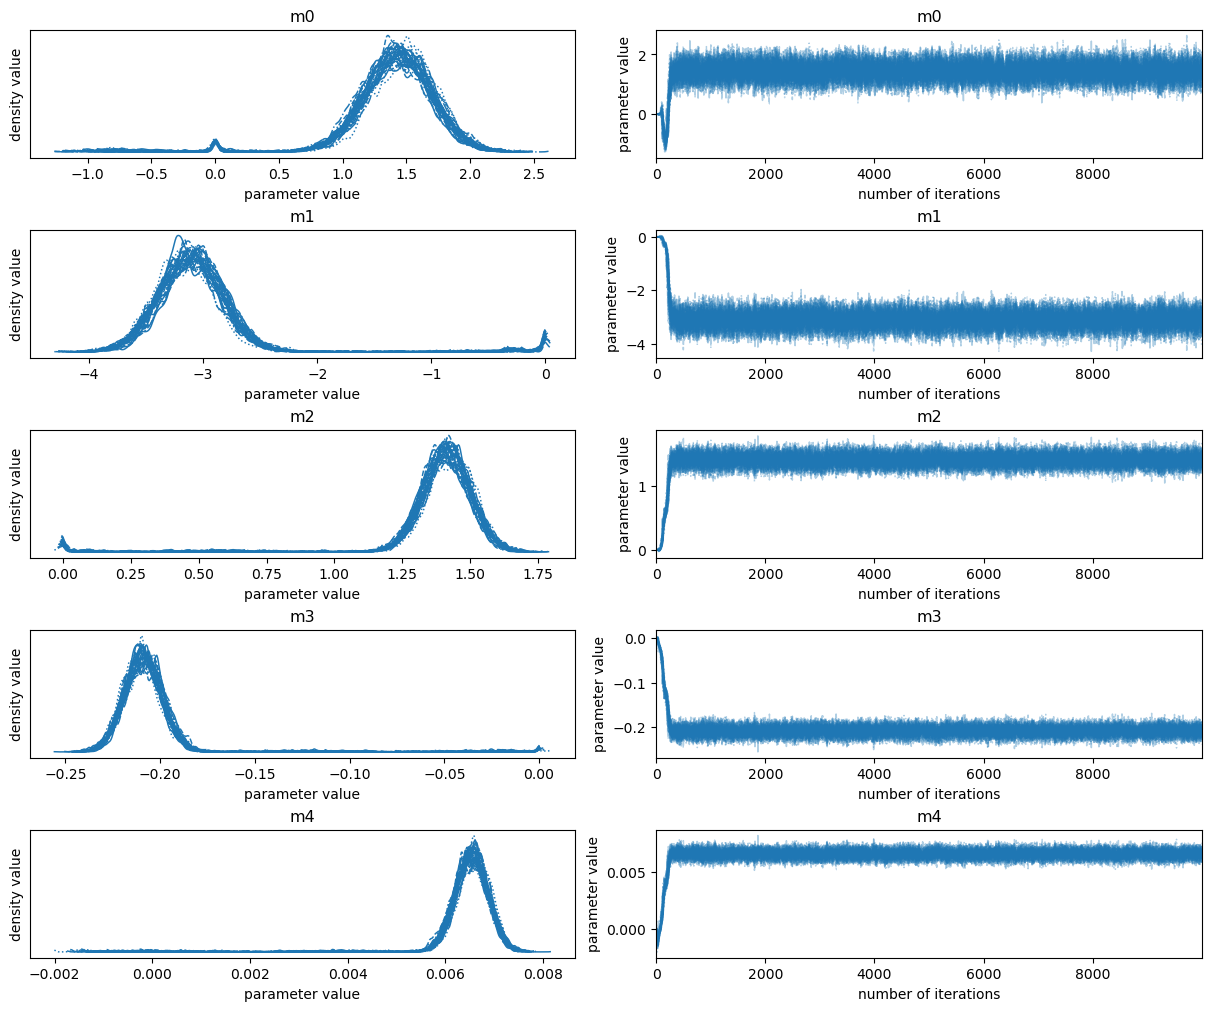

In [33]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    #ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [34]:
#tau = sampler.get_autocorr_time()
#print(f"autocorrelation time: {tau}")

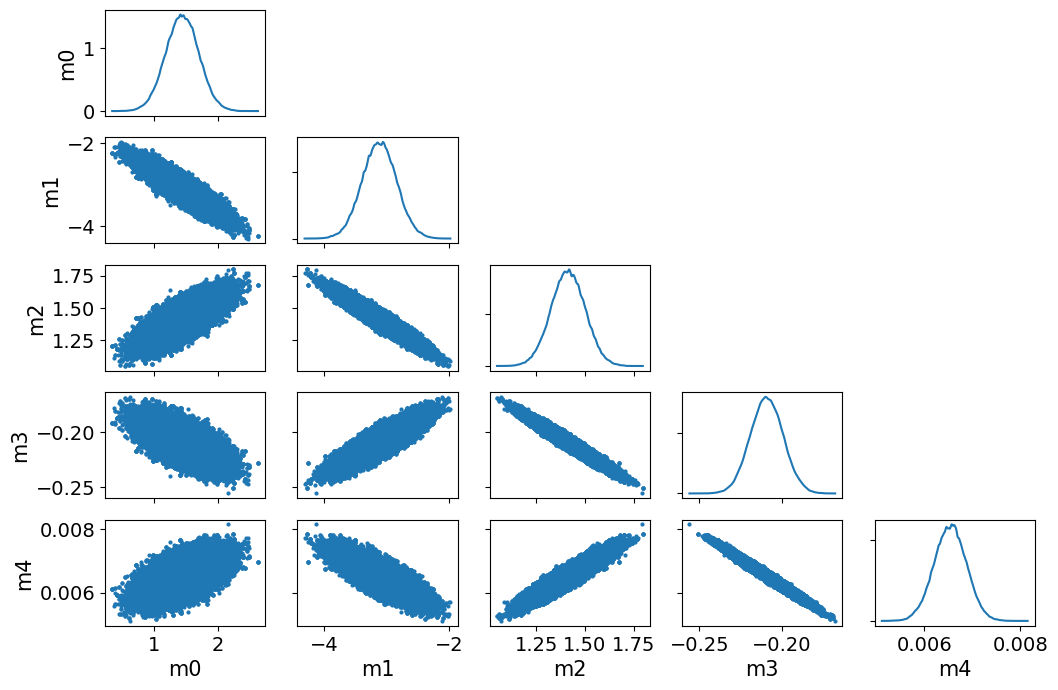

In [35]:
# a Corner plot

fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))

if(True): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );

Now we plot the predicted curves for the posterior ensemble of solutions.

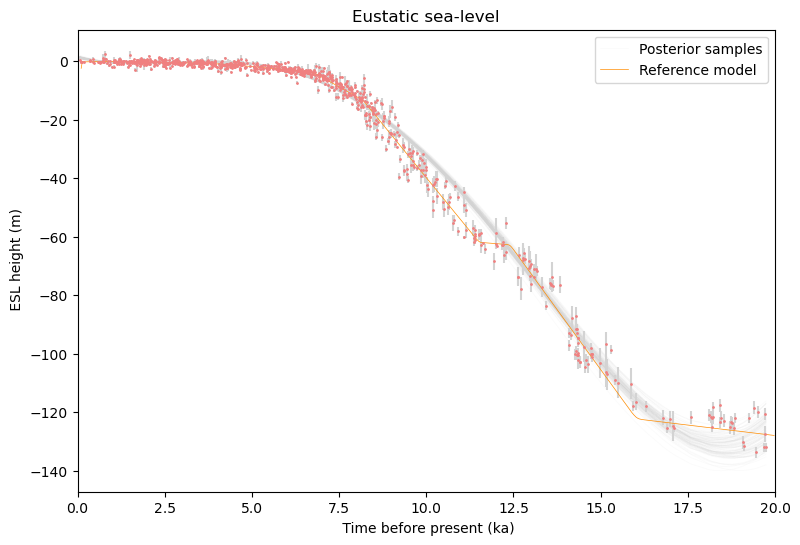

In [36]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data(title="Eustatic sea-level")
plt.xlim(0,maxtime)
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")
#plt.xlim(15,20.)
#plt.ylim(-140,-100)

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [37]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   1.437 [  1.009,   1.863]
 m1  -3.113 [ -3.569,  -2.659]
 m2   1.414 [  1.271,   1.555]
 m3  -0.209 [ -0.225,  -0.193]
 m4   0.007 [  0.006,   0.007]


In [38]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 6.75783953e-02 -6.35775183e-02  1.70173923e-02 -1.64412886e-03
   4.89408679e-05]
 [-6.35775183e-02  7.53113009e-02 -2.26979884e-02  2.36363077e-03
  -7.35122658e-05]
 [ 1.70173923e-02 -2.26979884e-02  7.50875911e-03 -8.35776826e-04
   2.70381230e-05]
 [-1.64412886e-03  2.36363077e-03 -8.35776826e-04  9.80350098e-05
  -3.27642175e-06]
 [ 4.89408679e-05 -7.35122658e-05  2.70381230e-05 -3.27642175e-06
   1.12344332e-07]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.2599
    m1  0.2744
    m2  0.0866
    m3  0.0099
    m4  0.0003


---------

### Challenge - Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-0.5,-10.,-10.,-10.)$, and ${\mathbf u}^T = (0.5,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [39]:
# Copy the template above, Replace <CHANGE ME> with your answer



  0%|                                                                                                                                                                                                                                                                  | 0/10000 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                                                                                                       | 13/10000 [00:00<01:20, 123.60it/s]

  0%|▋                                                                                                                                                                                                                                                       | 27/10000 [00:00<01:16, 130.10it/s]

  0%|█                                                                                                                                                                                                                                                       | 41/10000 [00:00<01:14, 133.04it/s]

  1%|█▎                                                                                                                                                                                                                                                      | 55/10000 [00:00<01:14, 133.99it/s]

  1%|█▋                                                                                                                                                                                                                                                      | 69/10000 [00:00<01:13, 134.80it/s]

  1%|██                                                                                                                                                                                                                                                      | 83/10000 [00:00<01:13, 135.35it/s]

  1%|██▍                                                                                                                                                                                                                                                     | 97/10000 [00:00<01:12, 136.37it/s]

  1%|██▊                                                                                                                                                                                                                                                    | 113/10000 [00:00<01:09, 141.60it/s]

  1%|███▏                                                                                                                                                                                                                                                   | 128/10000 [00:00<01:08, 143.81it/s]

  1%|███▌                                                                                                                                                                                                                                                   | 144/10000 [00:01<01:07, 146.07it/s]

  2%|███▉                                                                                                                                                                                                                                                   | 160/10000 [00:01<01:06, 148.09it/s]

  2%|████▎                                                                                                                                                                                                                                                  | 176/10000 [00:01<01:05, 149.47it/s]

  2%|████▋                                                                                                                                                                                                                                                  | 191/10000 [00:01<01:06, 147.36it/s]

  2%|█████                                                                                                                                                                                                                                                  | 206/10000 [00:01<01:07, 146.03it/s]

  2%|█████▍                                                                                                                                                                                                                                                 | 221/10000 [00:01<01:07, 145.37it/s]

  2%|█████▊                                                                                                                                                                                                                                                 | 236/10000 [00:01<01:06, 145.89it/s]

  3%|██████▏                                                                                                                                                                                                                                                | 251/10000 [00:01<01:06, 145.63it/s]

  3%|██████▌                                                                                                                                                                                                                                                | 266/10000 [00:01<01:06, 145.70it/s]

  3%|██████▉                                                                                                                                                                                                                                                | 281/10000 [00:01<01:06, 145.26it/s]

  3%|███████▎                                                                                                                                                                                                                                               | 296/10000 [00:02<01:06, 146.55it/s]

  3%|███████▋                                                                                                                                                                                                                                               | 311/10000 [00:02<01:06, 145.52it/s]

  3%|████████                                                                                                                                                                                                                                               | 326/10000 [00:02<01:05, 146.77it/s]

  3%|████████▍                                                                                                                                                                                                                                              | 342/10000 [00:02<01:04, 149.29it/s]

  4%|████████▊                                                                                                                                                                                                                                              | 358/10000 [00:02<01:03, 151.82it/s]

  4%|█████████▏                                                                                                                                                                                                                                             | 374/10000 [00:02<01:03, 152.47it/s]

  4%|█████████▋                                                                                                                                                                                                                                             | 390/10000 [00:02<01:02, 153.68it/s]

  4%|██████████                                                                                                                                                                                                                                             | 406/10000 [00:02<01:02, 153.94it/s]

  4%|██████████▍                                                                                                                                                                                                                                            | 422/10000 [00:02<01:02, 153.70it/s]

  4%|██████████▊                                                                                                                                                                                                                                            | 438/10000 [00:03<01:03, 150.72it/s]

  5%|███████████▏                                                                                                                                                                                                                                           | 454/10000 [00:03<01:13, 130.53it/s]

  5%|███████████▌                                                                                                                                                                                                                                           | 469/10000 [00:03<01:10, 135.49it/s]

  5%|███████████▉                                                                                                                                                                                                                                           | 483/10000 [00:03<01:15, 125.31it/s]

  5%|████████████▎                                                                                                                                                                                                                                          | 496/10000 [00:03<01:33, 101.38it/s]

  5%|████████████▌                                                                                                                                                                                                                                           | 508/10000 [00:03<01:53, 83.85it/s]

  5%|████████████▉                                                                                                                                                                                                                                           | 523/10000 [00:03<01:37, 97.36it/s]

  5%|█████████████▎                                                                                                                                                                                                                                          | 535/10000 [00:04<01:42, 92.02it/s]

  5%|█████████████▌                                                                                                                                                                                                                                         | 549/10000 [00:04<01:32, 102.04it/s]

  6%|█████████████▉                                                                                                                                                                                                                                         | 564/10000 [00:04<01:23, 113.39it/s]

  6%|██████████████▎                                                                                                                                                                                                                                        | 580/10000 [00:04<01:15, 124.20it/s]

  6%|██████████████▋                                                                                                                                                                                                                                        | 595/10000 [00:04<01:12, 129.86it/s]

  6%|███████████████                                                                                                                                                                                                                                        | 611/10000 [00:04<01:08, 136.96it/s]

  6%|███████████████▍                                                                                                                                                                                                                                       | 627/10000 [00:04<01:06, 141.35it/s]

  6%|███████████████▉                                                                                                                                                                                                                                       | 643/10000 [00:04<01:04, 144.00it/s]

  7%|████████████████▎                                                                                                                                                                                                                                      | 658/10000 [00:04<01:12, 128.01it/s]

  7%|████████████████▌                                                                                                                                                                                                                                      | 672/10000 [00:05<01:11, 130.10it/s]

  7%|████████████████▉                                                                                                                                                                                                                                      | 687/10000 [00:05<01:08, 135.07it/s]

  7%|█████████████████▎                                                                                                                                                                                                                                     | 703/10000 [00:05<01:06, 139.89it/s]

  7%|█████████████████▊                                                                                                                                                                                                                                     | 719/10000 [00:05<01:04, 143.70it/s]

  7%|██████████████████▏                                                                                                                                                                                                                                    | 735/10000 [00:05<01:03, 145.83it/s]

  8%|██████████████████▌                                                                                                                                                                                                                                    | 750/10000 [00:05<01:02, 146.88it/s]

  8%|██████████████████▉                                                                                                                                                                                                                                    | 766/10000 [00:05<01:01, 149.28it/s]

  8%|███████████████████▎                                                                                                                                                                                                                                   | 782/10000 [00:05<01:01, 150.23it/s]

  8%|███████████████████▋                                                                                                                                                                                                                                   | 798/10000 [00:05<01:18, 116.90it/s]

  8%|████████████████████                                                                                                                                                                                                                                   | 811/10000 [00:06<01:30, 102.09it/s]

  8%|████████████████████▎                                                                                                                                                                                                                                  | 823/10000 [00:06<01:29, 102.36it/s]

  8%|████████████████████▌                                                                                                                                                                                                                                  | 834/10000 [00:06<01:30, 101.25it/s]

  8%|████████████████████▉                                                                                                                                                                                                                                  | 846/10000 [00:06<01:26, 105.76it/s]

  9%|█████████████████████▎                                                                                                                                                                                                                                 | 862/10000 [00:06<01:17, 118.30it/s]

  9%|█████████████████████▋                                                                                                                                                                                                                                 | 877/10000 [00:06<01:12, 126.34it/s]

  9%|██████████████████████                                                                                                                                                                                                                                 | 892/10000 [00:06<01:09, 131.77it/s]

  9%|██████████████████████▍                                                                                                                                                                                                                                | 906/10000 [00:06<01:08, 132.80it/s]

  9%|██████████████████████▋                                                                                                                                                                                                                                | 921/10000 [00:06<01:06, 136.06it/s]

  9%|███████████████████████                                                                                                                                                                                                                                | 936/10000 [00:07<01:04, 139.91it/s]

 10%|███████████████████████▌                                                                                                                                                                                                                               | 952/10000 [00:07<01:02, 143.68it/s]

 10%|███████████████████████▉                                                                                                                                                                                                                               | 968/10000 [00:07<01:01, 146.49it/s]

 10%|████████████████████████▎                                                                                                                                                                                                                              | 983/10000 [00:07<01:10, 127.33it/s]

 10%|████████████████████████▋                                                                                                                                                                                                                              | 997/10000 [00:07<01:09, 130.14it/s]

 10%|████████████████████████▊                                                                                                                                                                                                                             | 1011/10000 [00:07<01:08, 130.83it/s]

 10%|█████████████████████████▏                                                                                                                                                                                                                            | 1026/10000 [00:07<01:06, 134.57it/s]

 10%|█████████████████████████▋                                                                                                                                                                                                                            | 1042/10000 [00:07<01:04, 139.17it/s]

 11%|██████████████████████████                                                                                                                                                                                                                            | 1058/10000 [00:07<01:02, 142.45it/s]

 11%|██████████████████████████▍                                                                                                                                                                                                                           | 1073/10000 [00:08<01:01, 144.60it/s]

 11%|██████████████████████████▊                                                                                                                                                                                                                           | 1089/10000 [00:08<01:02, 143.31it/s]

 11%|███████████████████████████▏                                                                                                                                                                                                                          | 1105/10000 [00:08<01:00, 146.18it/s]

 11%|███████████████████████████▌                                                                                                                                                                                                                          | 1121/10000 [00:08<01:00, 147.92it/s]

 11%|███████████████████████████▉                                                                                                                                                                                                                          | 1136/10000 [00:08<01:27, 101.45it/s]

 12%|████████████████████████████▎                                                                                                                                                                                                                         | 1151/10000 [00:08<01:19, 111.74it/s]

 12%|████████████████████████████▋                                                                                                                                                                                                                         | 1167/10000 [00:08<01:12, 121.97it/s]

 12%|█████████████████████████████                                                                                                                                                                                                                         | 1183/10000 [00:08<01:07, 130.49it/s]

 12%|█████████████████████████████▍                                                                                                                                                                                                                        | 1199/10000 [00:09<01:04, 136.14it/s]

 12%|█████████████████████████████▉                                                                                                                                                                                                                        | 1215/10000 [00:09<01:02, 140.58it/s]

 12%|██████████████████████████████▎                                                                                                                                                                                                                       | 1231/10000 [00:09<01:00, 144.78it/s]

 12%|██████████████████████████████▋                                                                                                                                                                                                                       | 1247/10000 [00:09<00:59, 146.64it/s]

 13%|███████████████████████████████                                                                                                                                                                                                                       | 1262/10000 [00:09<00:59, 147.07it/s]

 13%|███████████████████████████████▍                                                                                                                                                                                                                      | 1277/10000 [00:09<01:01, 140.85it/s]

 13%|███████████████████████████████▊                                                                                                                                                                                                                      | 1293/10000 [00:09<01:00, 144.42it/s]

 13%|████████████████████████████████▏                                                                                                                                                                                                                     | 1309/10000 [00:09<00:59, 147.21it/s]

 13%|████████████████████████████████▌                                                                                                                                                                                                                     | 1324/10000 [00:09<00:58, 147.86it/s]

 13%|████████████████████████████████▉                                                                                                                                                                                                                     | 1339/10000 [00:10<00:58, 147.82it/s]

 14%|█████████████████████████████████▎                                                                                                                                                                                                                    | 1355/10000 [00:10<00:58, 148.67it/s]

 14%|█████████████████████████████████▋                                                                                                                                                                                                                    | 1371/10000 [00:10<00:57, 149.42it/s]

 14%|██████████████████████████████████                                                                                                                                                                                                                    | 1387/10000 [00:10<00:56, 151.28it/s]

 14%|██████████████████████████████████▌                                                                                                                                                                                                                   | 1403/10000 [00:10<00:56, 152.55it/s]

 14%|██████████████████████████████████▉                                                                                                                                                                                                                   | 1419/10000 [00:10<00:59, 145.18it/s]

 14%|███████████████████████████████████▎                                                                                                                                                                                                                  | 1434/10000 [00:10<00:59, 144.83it/s]

 14%|███████████████████████████████████▋                                                                                                                                                                                                                  | 1449/10000 [00:10<00:59, 143.92it/s]

 15%|████████████████████████████████████                                                                                                                                                                                                                  | 1465/10000 [00:10<00:57, 147.92it/s]

 15%|████████████████████████████████████▍                                                                                                                                                                                                                 | 1482/10000 [00:10<00:56, 151.66it/s]

 15%|████████████████████████████████████▊                                                                                                                                                                                                                 | 1498/10000 [00:11<01:00, 140.53it/s]

 15%|█████████████████████████████████████▎                                                                                                                                                                                                                | 1515/10000 [00:11<00:57, 146.74it/s]

 15%|█████████████████████████████████████▋                                                                                                                                                                                                                | 1531/10000 [00:11<00:56, 149.37it/s]

 15%|██████████████████████████████████████                                                                                                                                                                                                                | 1547/10000 [00:11<00:56, 150.67it/s]

 16%|██████████████████████████████████████▍                                                                                                                                                                                                               | 1563/10000 [00:11<01:03, 132.35it/s]

 16%|██████████████████████████████████████▊                                                                                                                                                                                                               | 1578/10000 [00:11<01:01, 136.92it/s]

 16%|███████████████████████████████████████▏                                                                                                                                                                                                              | 1593/10000 [00:11<01:04, 130.44it/s]

 16%|███████████████████████████████████████▌                                                                                                                                                                                                              | 1609/10000 [00:11<01:01, 137.31it/s]

 16%|███████████████████████████████████████▉                                                                                                                                                                                                              | 1625/10000 [00:12<00:58, 143.02it/s]

 16%|████████████████████████████████████████▎                                                                                                                                                                                                             | 1641/10000 [00:12<00:57, 146.29it/s]

 17%|████████████████████████████████████████▊                                                                                                                                                                                                             | 1657/10000 [00:12<00:55, 149.28it/s]

 17%|█████████████████████████████████████████▏                                                                                                                                                                                                            | 1673/10000 [00:12<00:58, 142.86it/s]

 17%|█████████████████████████████████████████▌                                                                                                                                                                                                            | 1688/10000 [00:12<01:05, 126.04it/s]

 17%|█████████████████████████████████████████▉                                                                                                                                                                                                            | 1704/10000 [00:12<01:01, 134.15it/s]

 17%|██████████████████████████████████████████▎                                                                                                                                                                                                           | 1720/10000 [00:12<00:59, 139.88it/s]

 17%|██████████████████████████████████████████▋                                                                                                                                                                                                           | 1736/10000 [00:12<00:57, 144.40it/s]

 18%|███████████████████████████████████████████                                                                                                                                                                                                           | 1751/10000 [00:12<01:00, 137.16it/s]

 18%|███████████████████████████████████████████▌                                                                                                                                                                                                           | 1765/10000 [00:13<01:35, 86.49it/s]

 18%|███████████████████████████████████████████▉                                                                                                                                                                                                           | 1777/10000 [00:13<01:50, 74.56it/s]

 18%|████████████████████████████████████████████▏                                                                                                                                                                                                          | 1787/10000 [00:13<01:56, 70.62it/s]

 18%|████████████████████████████████████████████▎                                                                                                                                                                                                          | 1796/10000 [00:13<02:00, 67.90it/s]

 18%|████████████████████████████████████████████▋                                                                                                                                                                                                          | 1809/10000 [00:13<01:42, 79.78it/s]

 18%|█████████████████████████████████████████████                                                                                                                                                                                                          | 1825/10000 [00:13<01:24, 96.30it/s]

 18%|█████████████████████████████████████████████▎                                                                                                                                                                                                         | 1836/10000 [00:14<01:23, 97.53it/s]

 18%|█████████████████████████████████████████████▌                                                                                                                                                                                                         | 1847/10000 [00:14<01:23, 98.12it/s]

 19%|█████████████████████████████████████████████▉                                                                                                                                                                                                         | 1858/10000 [00:14<01:30, 89.63it/s]

 19%|██████████████████████████████████████████████▏                                                                                                                                                                                                        | 1868/10000 [00:14<01:42, 79.70it/s]

 19%|██████████████████████████████████████████████▎                                                                                                                                                                                                        | 1877/10000 [00:14<02:02, 66.39it/s]

 19%|██████████████████████████████████████████████▋                                                                                                                                                                                                        | 1891/10000 [00:14<01:42, 79.00it/s]

 19%|██████████████████████████████████████████████▉                                                                                                                                                                                                        | 1900/10000 [00:14<01:43, 78.27it/s]

 19%|███████████████████████████████████████████████▏                                                                                                                                                                                                       | 1909/10000 [00:15<01:45, 76.82it/s]

 19%|███████████████████████████████████████████████▍                                                                                                                                                                                                       | 1920/10000 [00:15<01:42, 78.85it/s]

 19%|███████████████████████████████████████████████▋                                                                                                                                                                                                       | 1929/10000 [00:15<01:42, 78.67it/s]

 19%|███████████████████████████████████████████████▉                                                                                                                                                                                                       | 1939/10000 [00:15<01:37, 82.82it/s]

 19%|████████████████████████████████████████████████                                                                                                                                                                                                       | 1948/10000 [00:15<01:46, 75.84it/s]

 20%|████████████████████████████████████████████████▍                                                                                                                                                                                                      | 1959/10000 [00:15<01:36, 83.07it/s]

 20%|████████████████████████████████████████████████▌                                                                                                                                                                                                     | 1974/10000 [00:15<01:19, 100.49it/s]

 20%|████████████████████████████████████████████████▉                                                                                                                                                                                                     | 1990/10000 [00:15<01:09, 114.78it/s]

 20%|█████████████████████████████████████████████████▎                                                                                                                                                                                                    | 2005/10000 [00:15<01:04, 123.78it/s]

 20%|█████████████████████████████████████████████████▋                                                                                                                                                                                                    | 2020/10000 [00:16<01:01, 129.99it/s]

 20%|██████████████████████████████████████████████████                                                                                                                                                                                                    | 2035/10000 [00:16<00:58, 135.67it/s]

 21%|██████████████████████████████████████████████████▍                                                                                                                                                                                                   | 2051/10000 [00:16<00:55, 142.05it/s]

 21%|██████████████████████████████████████████████████▊                                                                                                                                                                                                   | 2066/10000 [00:16<00:55, 144.05it/s]

 21%|███████████████████████████████████████████████████▏                                                                                                                                                                                                  | 2081/10000 [00:16<00:54, 145.24it/s]

 21%|███████████████████████████████████████████████████▌                                                                                                                                                                                                  | 2097/10000 [00:16<00:53, 147.77it/s]

 21%|███████████████████████████████████████████████████▉                                                                                                                                                                                                  | 2113/10000 [00:16<00:52, 148.94it/s]

 21%|████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 2128/10000 [00:16<00:59, 131.46it/s]

 21%|████████████████████████████████████████████████████▋                                                                                                                                                                                                 | 2143/10000 [00:16<00:58, 134.58it/s]

 22%|█████████████████████████████████████████████████████                                                                                                                                                                                                 | 2159/10000 [00:17<00:56, 139.85it/s]

 22%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                | 2175/10000 [00:17<00:54, 144.05it/s]

 22%|█████████████████████████████████████████████████████▉                                                                                                                                                                                                | 2191/10000 [00:17<00:53, 146.23it/s]

 22%|██████████████████████████████████████████████████████▎                                                                                                                                                                                               | 2206/10000 [00:17<01:01, 127.14it/s]

 22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                               | 2222/10000 [00:17<00:58, 133.51it/s]

 22%|███████████████████████████████████████████████████████                                                                                                                                                                                               | 2238/10000 [00:17<00:55, 139.50it/s]

 23%|███████████████████████████████████████████████████████▍                                                                                                                                                                                              | 2254/10000 [00:17<00:54, 143.19it/s]

 23%|███████████████████████████████████████████████████████▊                                                                                                                                                                                              | 2270/10000 [00:17<00:52, 146.00it/s]

 23%|████████████████████████████████████████████████████████▏                                                                                                                                                                                             | 2286/10000 [00:17<00:52, 147.89it/s]

 23%|████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 2301/10000 [00:18<00:53, 144.44it/s]

 23%|████████████████████████████████████████████████████████▉                                                                                                                                                                                             | 2317/10000 [00:18<00:52, 146.97it/s]

 23%|█████████████████████████████████████████████████████████▍                                                                                                                                                                                            | 2333/10000 [00:18<00:51, 149.25it/s]

 23%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 2348/10000 [00:18<00:51, 149.37it/s]

 24%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 2363/10000 [00:18<00:51, 147.80it/s]

 24%|██████████████████████████████████████████████████████████▌                                                                                                                                                                                           | 2379/10000 [00:18<00:50, 150.19it/s]

 24%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 2395/10000 [00:18<00:50, 149.29it/s]

 24%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 2410/10000 [00:18<00:53, 140.92it/s]

 24%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                          | 2425/10000 [00:18<00:52, 143.36it/s]

 24%|████████████████████████████████████████████████████████████                                                                                                                                                                                          | 2441/10000 [00:19<00:51, 146.70it/s]

 25%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 2457/10000 [00:19<00:50, 150.37it/s]

 25%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 2473/10000 [00:19<00:50, 150.42it/s]

 25%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                        | 2489/10000 [00:19<00:58, 127.60it/s]

 25%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                                        | 2505/10000 [00:19<00:55, 133.94it/s]

 25%|██████████████████████████████████████████████████████████████                                                                                                                                                                                        | 2521/10000 [00:19<00:53, 139.62it/s]

 25%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                       | 2537/10000 [00:19<00:51, 143.82it/s]

 26%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                       | 2553/10000 [00:19<00:50, 146.27it/s]

 26%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 2569/10000 [00:19<00:50, 147.81it/s]

 26%|███████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 2585/10000 [00:20<00:49, 149.34it/s]

 26%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 2601/10000 [00:20<00:49, 150.90it/s]

 26%|████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 2617/10000 [00:20<00:48, 151.77it/s]

 26%|████████████████████████████████████████████████████████████████▊                                                                                                                                                                                     | 2633/10000 [00:20<00:48, 152.15it/s]

 26%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 2649/10000 [00:20<00:48, 150.97it/s]

 27%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                    | 2665/10000 [00:20<00:48, 151.77it/s]

 27%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 2681/10000 [00:20<00:47, 152.73it/s]

 27%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 2697/10000 [00:20<00:47, 153.83it/s]

 27%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 2713/10000 [00:20<00:47, 153.82it/s]

 27%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 2729/10000 [00:20<00:47, 153.78it/s]

 27%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 2745/10000 [00:21<00:47, 152.65it/s]

 28%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 2761/10000 [00:21<00:47, 152.75it/s]

 28%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 2777/10000 [00:21<00:47, 153.02it/s]

 28%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                 | 2793/10000 [00:21<00:46, 154.34it/s]

 28%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 2809/10000 [00:21<00:46, 154.35it/s]

 28%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 2825/10000 [00:21<00:46, 153.42it/s]

 28%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 2841/10000 [00:21<00:46, 153.68it/s]

 29%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 2857/10000 [00:21<00:46, 153.16it/s]

 29%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 2873/10000 [00:21<00:46, 153.49it/s]

 29%|███████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 2889/10000 [00:21<00:46, 153.58it/s]

 29%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                              | 2905/10000 [00:22<00:46, 152.49it/s]

 29%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 2921/10000 [00:22<00:46, 151.65it/s]

 29%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 2937/10000 [00:22<00:46, 151.83it/s]

 30%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 2953/10000 [00:22<00:46, 152.30it/s]

 30%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 2969/10000 [00:22<00:46, 151.17it/s]

 30%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 2985/10000 [00:22<00:46, 150.74it/s]

 30%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 3001/10000 [00:22<00:45, 152.32it/s]

 30%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 3017/10000 [00:22<00:45, 153.34it/s]

 30%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 3033/10000 [00:22<00:45, 153.91it/s]

 30%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                           | 3049/10000 [00:23<00:45, 153.69it/s]

 31%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                          | 3065/10000 [00:23<00:44, 154.16it/s]

 31%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 3081/10000 [00:23<00:44, 154.79it/s]

 31%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 3097/10000 [00:23<00:45, 152.65it/s]

 31%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                         | 3113/10000 [00:23<00:44, 153.79it/s]

 31%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                         | 3129/10000 [00:23<00:44, 153.77it/s]

 31%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 3145/10000 [00:23<00:44, 152.34it/s]

 32%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 3161/10000 [00:23<00:45, 151.93it/s]

 32%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                       | 3177/10000 [00:23<00:44, 153.51it/s]

 32%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 3193/10000 [00:23<00:44, 151.91it/s]

 32%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 3209/10000 [00:24<00:45, 149.65it/s]

 32%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 3225/10000 [00:24<00:45, 150.17it/s]

 32%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 3241/10000 [00:24<00:47, 141.54it/s]

 33%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 3256/10000 [00:24<00:59, 113.75it/s]

 33%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 3269/10000 [00:24<01:04, 104.73it/s]

 33%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 3281/10000 [00:24<01:07, 100.25it/s]

 33%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 3292/10000 [00:24<01:09, 96.76it/s]

 33%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                     | 3302/10000 [00:25<01:10, 95.08it/s]

 33%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 3313/10000 [00:25<01:08, 98.14it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 3324/10000 [00:25<01:07, 98.71it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                    | 3335/10000 [00:25<01:05, 101.37it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 3346/10000 [00:25<01:04, 103.52it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 3357/10000 [00:25<01:06, 100.62it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 3368/10000 [00:25<01:09, 95.82it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 3380/10000 [00:25<01:05, 101.71it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 3393/10000 [00:25<01:00, 108.47it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                  | 3407/10000 [00:26<00:56, 116.28it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 3423/10000 [00:26<00:51, 127.07it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 3439/10000 [00:26<00:48, 135.32it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 3455/10000 [00:26<00:46, 140.18it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 3470/10000 [00:26<00:45, 142.44it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 3485/10000 [00:26<00:46, 141.31it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                | 3500/10000 [00:26<00:46, 140.74it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                               | 3515/10000 [00:26<00:45, 141.10it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 3530/10000 [00:26<00:45, 141.20it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 3545/10000 [00:26<00:46, 138.98it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 3559/10000 [00:27<00:46, 139.11it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 3574/10000 [00:27<00:45, 140.79it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 3589/10000 [00:27<00:44, 142.93it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 3604/10000 [00:27<00:44, 143.45it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 3619/10000 [00:27<00:44, 143.10it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 3634/10000 [00:27<00:43, 144.97it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 3649/10000 [00:27<00:44, 141.41it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 3664/10000 [00:27<00:44, 141.66it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 3679/10000 [00:27<00:44, 142.28it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 3694/10000 [00:28<00:45, 139.46it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 3709/10000 [00:28<00:44, 141.86it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 3724/10000 [00:28<00:43, 142.78it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 3739/10000 [00:28<00:43, 143.88it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 3754/10000 [00:28<00:50, 124.44it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 3767/10000 [00:28<00:56, 109.86it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 3780/10000 [00:28<00:57, 108.29it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 3793/10000 [00:28<00:57, 107.03it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 3806/10000 [00:29<00:58, 105.77it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 3820/10000 [00:29<00:54, 113.78it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 3837/10000 [00:29<00:48, 126.63it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 3853/10000 [00:29<00:46, 133.53it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 3867/10000 [00:29<00:45, 135.28it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 3882/10000 [00:29<00:44, 138.95it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 3897/10000 [00:29<00:43, 141.53it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 3912/10000 [00:29<00:42, 143.74it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 3928/10000 [00:29<00:41, 146.46it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 3943/10000 [00:29<00:41, 146.85it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 3958/10000 [00:30<00:41, 146.73it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 3973/10000 [00:30<00:53, 111.79it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 3988/10000 [00:30<00:49, 120.77it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 4003/10000 [00:30<00:47, 127.52it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 4019/10000 [00:30<00:44, 134.68it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 4035/10000 [00:30<00:42, 139.95it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 4050/10000 [00:30<00:42, 141.02it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 4066/10000 [00:30<00:41, 144.36it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 4082/10000 [00:30<00:40, 146.47it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 4098/10000 [00:31<00:39, 147.79it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 4114/10000 [00:31<00:39, 148.99it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 4129/10000 [00:31<00:39, 146.97it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 4144/10000 [00:31<00:39, 146.77it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 4159/10000 [00:31<00:40, 144.29it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 4174/10000 [00:31<00:40, 145.06it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 4189/10000 [00:31<00:40, 144.53it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 4204/10000 [00:31<00:39, 145.63it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 4219/10000 [00:31<00:45, 127.40it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 4234/10000 [00:32<00:43, 131.62it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 4248/10000 [00:32<00:43, 133.09it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 4262/10000 [00:32<00:50, 113.26it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 4278/10000 [00:32<00:46, 123.32it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 4291/10000 [00:32<00:50, 112.76it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 4304/10000 [00:32<00:48, 116.66it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 4317/10000 [00:32<01:11, 79.29it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 4328/10000 [00:33<01:08, 82.83it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 4338/10000 [00:33<01:18, 72.28it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 4347/10000 [00:33<01:15, 75.10it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 4356/10000 [00:33<01:14, 75.35it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 4371/10000 [00:33<01:00, 92.72it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 4386/10000 [00:33<00:52, 106.37it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 4398/10000 [00:33<00:52, 106.30it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 4410/10000 [00:33<00:52, 105.50it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 4425/10000 [00:34<00:47, 117.13it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 4441/10000 [00:34<00:43, 127.18it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 4457/10000 [00:34<00:40, 135.25it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 4472/10000 [00:34<00:40, 137.46it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 4487/10000 [00:34<00:39, 139.85it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 4502/10000 [00:34<00:39, 138.37it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 4518/10000 [00:34<00:38, 142.68it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 4534/10000 [00:34<00:37, 145.82it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 4550/10000 [00:34<00:36, 148.25it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 4566/10000 [00:35<00:36, 150.23it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 4582/10000 [00:35<00:35, 150.57it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 4598/10000 [00:35<00:35, 150.95it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 4614/10000 [00:35<00:35, 150.95it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 4630/10000 [00:35<00:35, 151.30it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 4646/10000 [00:35<00:35, 150.67it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 4662/10000 [00:35<00:35, 150.54it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 4678/10000 [00:35<00:35, 148.09it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 4694/10000 [00:35<00:35, 149.04it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 4710/10000 [00:35<00:35, 149.70it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 4726/10000 [00:36<00:34, 151.05it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 4742/10000 [00:36<00:34, 151.65it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 4758/10000 [00:36<00:34, 151.59it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 4774/10000 [00:36<00:34, 151.01it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 4790/10000 [00:36<00:34, 150.05it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 4806/10000 [00:36<00:34, 150.80it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 4822/10000 [00:36<00:34, 150.16it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 4838/10000 [00:36<00:34, 150.67it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 4854/10000 [00:36<00:34, 150.19it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 4870/10000 [00:37<00:35, 144.44it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 4885/10000 [00:37<00:35, 144.13it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 4901/10000 [00:37<00:34, 146.50it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 4916/10000 [00:37<00:35, 145.13it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 4932/10000 [00:37<00:34, 145.08it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 4948/10000 [00:37<00:34, 147.10it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 4964/10000 [00:37<00:33, 148.36it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 4980/10000 [00:37<00:33, 151.67it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 4996/10000 [00:37<00:33, 151.58it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 5012/10000 [00:37<00:32, 151.83it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 5028/10000 [00:38<00:32, 152.31it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 5044/10000 [00:38<00:32, 153.26it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 5060/10000 [00:38<00:32, 153.05it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 5076/10000 [00:38<00:32, 152.47it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 5092/10000 [00:38<00:32, 152.50it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 5108/10000 [00:38<00:32, 151.58it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 5124/10000 [00:38<00:32, 151.37it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 5140/10000 [00:38<00:31, 152.98it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 5156/10000 [00:38<00:31, 153.17it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 5172/10000 [00:39<00:31, 153.70it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 5188/10000 [00:39<00:31, 152.90it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 5204/10000 [00:39<00:31, 153.68it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 5220/10000 [00:39<00:30, 154.21it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 5236/10000 [00:39<00:30, 153.75it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 5252/10000 [00:39<00:30, 153.87it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 5268/10000 [00:39<00:30, 154.25it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 5284/10000 [00:39<00:30, 154.61it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 5300/10000 [00:39<00:30, 153.33it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 5316/10000 [00:39<00:30, 152.88it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 5332/10000 [00:40<00:30, 151.92it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 5348/10000 [00:40<00:31, 149.33it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 5364/10000 [00:40<00:30, 149.92it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 5380/10000 [00:40<00:30, 151.10it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 5396/10000 [00:40<00:30, 148.65it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 5412/10000 [00:40<00:30, 150.12it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 5428/10000 [00:40<00:30, 150.11it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 5444/10000 [00:40<00:30, 149.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 5460/10000 [00:40<00:30, 151.29it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 5476/10000 [00:41<00:29, 151.91it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 5492/10000 [00:41<00:29, 151.79it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 5508/10000 [00:41<00:29, 151.07it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 5524/10000 [00:41<00:29, 151.13it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 5540/10000 [00:41<00:29, 152.91it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 5556/10000 [00:41<00:28, 153.43it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 5572/10000 [00:41<00:29, 152.66it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 5588/10000 [00:41<00:28, 153.40it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 5604/10000 [00:41<00:28, 152.65it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 5620/10000 [00:41<00:28, 153.75it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 5636/10000 [00:42<00:28, 152.64it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 5652/10000 [00:42<00:29, 146.62it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 5667/10000 [00:42<00:29, 147.36it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 5682/10000 [00:42<00:29, 148.09it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 5698/10000 [00:42<00:28, 148.74it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 5713/10000 [00:42<00:28, 148.38it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 5729/10000 [00:42<00:28, 149.95it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 5745/10000 [00:42<00:28, 151.55it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 5761/10000 [00:42<00:27, 152.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 5777/10000 [00:43<00:35, 118.52it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 5791/10000 [00:43<00:34, 121.05it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 5806/10000 [00:43<00:32, 127.81it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 5821/10000 [00:43<00:31, 133.37it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 5836/10000 [00:43<00:30, 137.54it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 5852/10000 [00:43<00:29, 141.65it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 5868/10000 [00:43<00:28, 145.50it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 5884/10000 [00:43<00:27, 148.33it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 5900/10000 [00:43<00:27, 148.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 5916/10000 [00:44<00:27, 148.18it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 5932/10000 [00:44<00:27, 148.91it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 5947/10000 [00:44<00:27, 148.58it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 5963/10000 [00:44<00:26, 150.38it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 5979/10000 [00:44<00:26, 151.24it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 5995/10000 [00:44<00:26, 151.49it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 6011/10000 [00:44<00:26, 151.06it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 6027/10000 [00:44<00:29, 132.59it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 6041/10000 [00:45<00:35, 110.45it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 6053/10000 [00:45<00:38, 102.57it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 6069/10000 [00:45<00:34, 115.61it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 6085/10000 [00:45<00:31, 125.13it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 6101/10000 [00:45<00:29, 133.41it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 6117/10000 [00:45<00:27, 138.75it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 6133/10000 [00:45<00:27, 142.07it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 6148/10000 [00:45<00:26, 144.06it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 6164/10000 [00:45<00:26, 146.21it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 6180/10000 [00:46<00:25, 148.16it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 6196/10000 [00:46<00:25, 150.65it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 6212/10000 [00:46<00:25, 149.52it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 6228/10000 [00:46<00:24, 151.32it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 6244/10000 [00:46<00:24, 152.03it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 6260/10000 [00:46<00:24, 149.60it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 6276/10000 [00:46<00:24, 150.40it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 6292/10000 [00:46<00:24, 150.95it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 6308/10000 [00:46<00:24, 150.46it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 6324/10000 [00:46<00:24, 149.97it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 6340/10000 [00:47<00:24, 150.63it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 6356/10000 [00:47<00:24, 149.85it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 6371/10000 [00:47<00:24, 149.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 6387/10000 [00:47<00:23, 150.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 6403/10000 [00:47<00:24, 148.14it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 6418/10000 [00:47<00:31, 112.85it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 6431/10000 [00:47<00:35, 101.19it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 6446/10000 [00:47<00:31, 112.23it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 6462/10000 [00:48<00:28, 123.30it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 6478/10000 [00:48<00:26, 132.37it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 6494/10000 [00:48<00:25, 138.78it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 6509/10000 [00:48<00:24, 141.70it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 6525/10000 [00:48<00:24, 144.34it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 6541/10000 [00:48<00:23, 146.46it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 6557/10000 [00:48<00:23, 148.13it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 6572/10000 [00:48<00:23, 148.63it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 6588/10000 [00:48<00:22, 149.37it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 6604/10000 [00:48<00:22, 150.14it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 6620/10000 [00:49<00:22, 151.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 6636/10000 [00:49<00:22, 151.79it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 6652/10000 [00:49<00:22, 151.97it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 6668/10000 [00:49<00:21, 151.82it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 6684/10000 [00:49<00:22, 149.37it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 6700/10000 [00:49<00:21, 150.42it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 6716/10000 [00:49<00:22, 144.48it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 6732/10000 [00:49<00:22, 147.69it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 6748/10000 [00:49<00:21, 148.98it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 6763/10000 [00:50<00:21, 148.84it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 6779/10000 [00:50<00:21, 149.67it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 6795/10000 [00:50<00:21, 150.68it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 6811/10000 [00:50<00:21, 151.14it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 6827/10000 [00:50<00:21, 150.35it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 6843/10000 [00:50<00:21, 145.30it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 6859/10000 [00:50<00:21, 147.65it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 6875/10000 [00:50<00:20, 148.96it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 6891/10000 [00:50<00:20, 149.51it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 6906/10000 [00:51<00:20, 149.09it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 6922/10000 [00:51<00:20, 149.90it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 6937/10000 [00:51<00:20, 149.76it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 6953/10000 [00:51<00:20, 151.80it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 6969/10000 [00:51<00:19, 152.91it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 6985/10000 [00:51<00:19, 153.08it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 7001/10000 [00:51<00:19, 153.35it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 7017/10000 [00:51<00:19, 153.32it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 7033/10000 [00:51<00:19, 153.69it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 7049/10000 [00:51<00:19, 151.45it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 7065/10000 [00:52<00:19, 151.68it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 7081/10000 [00:52<00:19, 151.57it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 7097/10000 [00:52<00:19, 148.05it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 7112/10000 [00:52<00:19, 147.52it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 7127/10000 [00:52<00:19, 147.67it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 7142/10000 [00:52<00:22, 129.17it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 7156/10000 [00:52<00:24, 117.35it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 7172/10000 [00:52<00:22, 127.38it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 7188/10000 [00:52<00:20, 135.00it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 7204/10000 [00:53<00:19, 140.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 7220/10000 [00:53<00:19, 144.28it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 7235/10000 [00:53<00:18, 145.57it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 7251/10000 [00:53<00:18, 147.49it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 7267/10000 [00:53<00:18, 149.07it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 7283/10000 [00:53<00:18, 149.43it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 7299/10000 [00:53<00:18, 149.69it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 7315/10000 [00:53<00:18, 142.74it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 7331/10000 [00:53<00:18, 145.11it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 7347/10000 [00:54<00:17, 147.71it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 7363/10000 [00:54<00:17, 150.26it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 7379/10000 [00:54<00:17, 151.60it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 7395/10000 [00:54<00:17, 150.71it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 7411/10000 [00:54<00:17, 150.94it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 7427/10000 [00:54<00:17, 151.23it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 7443/10000 [00:54<00:16, 152.30it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 7459/10000 [00:54<00:16, 152.25it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 7475/10000 [00:54<00:16, 152.46it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 7491/10000 [00:54<00:16, 153.97it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 7507/10000 [00:55<00:16, 155.38it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 7523/10000 [00:55<00:15, 156.04it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 7539/10000 [00:55<00:15, 154.63it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 7555/10000 [00:55<00:15, 153.21it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 7571/10000 [00:55<00:16, 150.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 7587/10000 [00:55<00:15, 152.11it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 7603/10000 [00:55<00:15, 152.41it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 7619/10000 [00:55<00:15, 151.22it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7635/10000 [00:55<00:15, 150.81it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 7651/10000 [00:56<00:15, 151.22it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 7667/10000 [00:56<00:15, 150.46it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 7683/10000 [00:56<00:15, 150.05it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 7699/10000 [00:56<00:15, 150.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 7715/10000 [00:56<00:15, 151.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 7731/10000 [00:56<00:14, 152.20it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 7747/10000 [00:56<00:14, 152.38it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 7763/10000 [00:56<00:14, 152.06it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 7779/10000 [00:56<00:14, 153.53it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 7795/10000 [00:56<00:14, 154.23it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 7811/10000 [00:57<00:14, 150.57it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 7827/10000 [00:57<00:14, 147.73it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7843/10000 [00:57<00:14, 150.03it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 7859/10000 [00:57<00:14, 150.73it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 7875/10000 [00:57<00:16, 126.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 7889/10000 [00:57<00:18, 113.69it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 7904/10000 [00:57<00:17, 122.39it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 7920/10000 [00:57<00:15, 130.36it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 7936/10000 [00:58<00:15, 137.18it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 7951/10000 [00:58<00:14, 140.10it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 7966/10000 [00:58<00:14, 141.90it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 7981/10000 [00:58<00:14, 143.73it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 7996/10000 [00:58<00:13, 143.73it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 8012/10000 [00:58<00:13, 146.33it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 8028/10000 [00:58<00:13, 147.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 8043/10000 [00:58<00:13, 147.66it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 8059/10000 [00:58<00:13, 149.26it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 8075/10000 [00:58<00:12, 150.75it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 8091/10000 [00:59<00:12, 150.24it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 8107/10000 [00:59<00:12, 150.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 8123/10000 [00:59<00:12, 151.72it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 8139/10000 [00:59<00:12, 152.94it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 8155/10000 [00:59<00:12, 152.40it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 8171/10000 [00:59<00:11, 153.00it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 8187/10000 [00:59<00:11, 153.39it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 8203/10000 [00:59<00:11, 154.40it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 8219/10000 [00:59<00:11, 154.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 8235/10000 [01:00<00:11, 154.83it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 8251/10000 [01:00<00:11, 154.86it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 8267/10000 [01:00<00:11, 156.17it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 8283/10000 [01:00<00:11, 155.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 8299/10000 [01:00<00:15, 112.45it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 8314/10000 [01:00<00:14, 119.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 8329/10000 [01:00<00:13, 126.88it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 8343/10000 [01:00<00:13, 127.30it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 8359/10000 [01:00<00:12, 134.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 8375/10000 [01:01<00:11, 138.98it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 8391/10000 [01:01<00:11, 142.91it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 8406/10000 [01:01<00:11, 135.01it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8422/10000 [01:01<00:11, 140.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 8437/10000 [01:01<00:10, 142.34it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 8452/10000 [01:01<00:10, 142.51it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 8468/10000 [01:01<00:10, 145.39it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 8484/10000 [01:01<00:10, 148.10it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 8500/10000 [01:01<00:10, 149.69it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 8516/10000 [01:02<00:09, 150.75it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 8532/10000 [01:02<00:09, 153.34it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 8548/10000 [01:02<00:09, 153.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 8564/10000 [01:02<00:09, 146.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 8579/10000 [01:02<00:09, 147.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 8595/10000 [01:02<00:09, 149.95it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 8611/10000 [01:02<00:09, 150.19it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 8627/10000 [01:02<00:09, 152.29it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 8643/10000 [01:02<00:08, 153.58it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 8659/10000 [01:02<00:08, 153.13it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 8675/10000 [01:03<00:08, 153.28it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 8691/10000 [01:03<00:08, 153.33it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8707/10000 [01:03<00:08, 152.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8723/10000 [01:03<00:08, 151.67it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 8739/10000 [01:03<00:08, 151.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 8755/10000 [01:03<00:08, 150.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 8771/10000 [01:03<00:08, 150.47it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 8787/10000 [01:03<00:08, 149.34it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8802/10000 [01:03<00:08, 149.42it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 8817/10000 [01:04<00:08, 145.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 8833/10000 [01:04<00:07, 148.64it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8848/10000 [01:04<00:07, 148.79it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8864/10000 [01:04<00:07, 150.77it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8880/10000 [01:04<00:07, 148.37it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8895/10000 [01:04<00:07, 143.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8910/10000 [01:04<00:07, 145.22it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8925/10000 [01:04<00:09, 111.02it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8938/10000 [01:05<00:09, 107.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8950/10000 [01:05<00:10, 97.01it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8961/10000 [01:05<00:11, 90.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8971/10000 [01:05<00:11, 92.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8987/10000 [01:05<00:09, 107.44it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 9003/10000 [01:05<00:08, 120.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 9019/10000 [01:05<00:07, 130.21it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 9035/10000 [01:05<00:06, 138.36it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 9050/10000 [01:05<00:06, 140.71it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 9065/10000 [01:06<00:06, 138.03it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 9081/10000 [01:06<00:06, 142.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 9097/10000 [01:06<00:06, 146.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 9113/10000 [01:06<00:05, 148.26it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 9129/10000 [01:06<00:05, 149.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 9145/10000 [01:06<00:05, 149.35it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 9161/10000 [01:06<00:05, 150.93it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 9177/10000 [01:06<00:05, 151.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 9193/10000 [01:06<00:05, 152.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9209/10000 [01:07<00:05, 150.95it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 9225/10000 [01:07<00:05, 151.61it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 9241/10000 [01:07<00:05, 151.05it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 9257/10000 [01:07<00:04, 151.44it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 9273/10000 [01:07<00:05, 143.01it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9288/10000 [01:07<00:04, 143.80it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 9304/10000 [01:07<00:04, 146.36it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 9319/10000 [01:07<00:04, 146.83it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 9335/10000 [01:07<00:04, 148.32it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9351/10000 [01:07<00:04, 149.57it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 9367/10000 [01:08<00:04, 149.96it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 9383/10000 [01:08<00:04, 151.33it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9399/10000 [01:08<00:03, 151.51it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9415/10000 [01:08<00:03, 151.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9431/10000 [01:08<00:03, 151.35it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9447/10000 [01:08<00:03, 151.08it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9463/10000 [01:08<00:03, 150.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 9479/10000 [01:08<00:03, 150.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9495/10000 [01:08<00:03, 151.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9511/10000 [01:09<00:03, 132.93it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9525/10000 [01:09<00:04, 111.52it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9537/10000 [01:09<00:04, 104.42it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9548/10000 [01:09<00:04, 97.46it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9563/10000 [01:09<00:04, 108.70it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9575/10000 [01:09<00:04, 105.33it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9591/10000 [01:09<00:03, 117.94it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9607/10000 [01:09<00:03, 127.32it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9623/10000 [01:10<00:02, 134.91it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9639/10000 [01:10<00:02, 140.79it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9655/10000 [01:10<00:02, 144.33it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9671/10000 [01:10<00:02, 146.73it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9686/10000 [01:10<00:02, 145.77it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9702/10000 [01:10<00:02, 147.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9718/10000 [01:10<00:01, 148.39it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9733/10000 [01:10<00:01, 147.63it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9749/10000 [01:10<00:01, 148.39it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9765/10000 [01:11<00:01, 150.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9781/10000 [01:11<00:01, 150.31it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9797/10000 [01:11<00:01, 151.21it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9813/10000 [01:11<00:01, 152.28it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9829/10000 [01:11<00:01, 147.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9845/10000 [01:11<00:01, 149.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9861/10000 [01:11<00:00, 150.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9877/10000 [01:11<00:00, 150.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9893/10000 [01:11<00:00, 151.32it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9909/10000 [01:11<00:00, 151.57it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9925/10000 [01:12<00:00, 151.24it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9941/10000 [01:12<00:00, 150.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9957/10000 [01:12<00:00, 150.89it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9973/10000 [01:12<00:00, 152.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9989/10000 [01:12<00:00, 152.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 137.81it/s]

Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


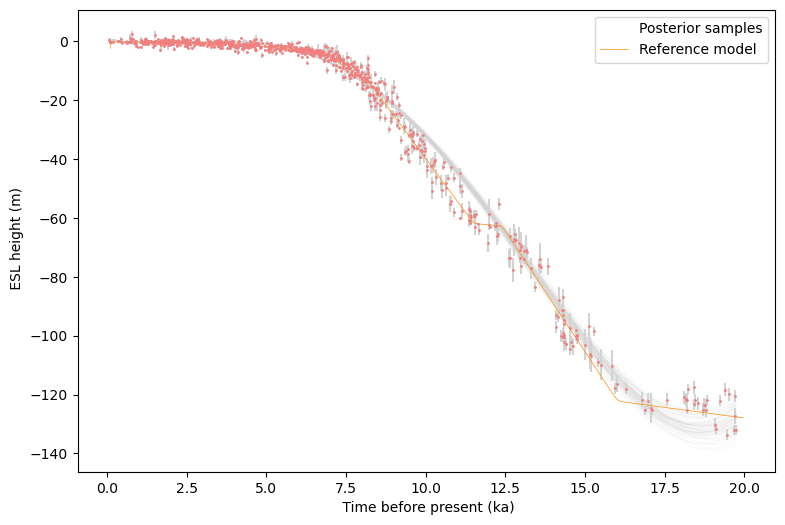

In [40]:
#@title Solution

m_lower_bound = np.array([-1.0,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([1.0,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x, ref_y, "Reference model", color="darkorange")

Is there much change to the posterior distribution?

---

## Watermark

In [41]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.3.dev2
numpy 1.23.5
scipy 1.10.1
matplotlib 3.5.1
emcee 3.1.4
arviz 0.15.1
